Entrega : 01

Grupo : 07

# Load

In [1]:
##Instalamos las librerias
import pandas as pd
import numpy as np
import os
from pathlib import Path 
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer

# pre processing categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Ruta Maria
#path_proyecto ='/content/drive/MyDrive/Machine Learning_Entregables/Entregable 1/data_inter' #### Ruta a cambiar

# os.chdir(path_proyecto)
# os.getcwd()

In [4]:
# Ruta Eliane
# path_proyecto ='/content/drive/MyDrive/2026/2026-0/Machine learning/data_inter' #### Ruta a cambiar

# os.chdir(path_proyecto)
# os.getcwd()

In [5]:
# Obtener directorio base (Grupo07) - subir un nivel desde scripts
BASE_DIR = Path(__file__).parent.parent if '__file__' in dir() else Path.cwd().parent

# Si estamos en scripts, subir un nivel; si no, usar cwd
if "scripts" in str(Path.cwd()):
    BASE_DIR = Path.cwd().parent
else:
    BASE_DIR = Path.cwd()

print(f"BASE_DIR: {BASE_DIR}")

# Rutas para datos
DATA_DIR = BASE_DIR / "data"
RAW_DATA_PATH = DATA_DIR / "raw"
INTER_DATA_PATH = DATA_DIR / "inter"
FINAL_DATA_PATH = DATA_DIR / "final"
# Rutas para gráficos, scripts y documentación
GRAPHS_DIR = BASE_DIR / "graphs"
GRAPHS_PATH_INCOME = GRAPHS_DIR / "data_income"
GRAPHS_PATH_LENDING = GRAPHS_DIR / "data_lending"
SCRIPTS_PATH = BASE_DIR / "scripts"
DOCS_PATH = BASE_DIR / "docs"

print(f"RAW_DATA_PATH: {RAW_DATA_PATH}")
print(f"Existe: {RAW_DATA_PATH.exists()}")

BASE_DIR: c:\Users\leydi\Documents\Machine-Learning-para-Finanzas_2026_0\Grupo07
RAW_DATA_PATH: c:\Users\leydi\Documents\Machine-Learning-para-Finanzas_2026_0\Grupo07\data\raw
Existe: True


In [6]:
# cargando datos
df_lending_raw = pd.read_excel(RAW_DATA_PATH / "lending_dataset.xlsx")
df_lending_raw = df_lending_raw.drop(columns=["index"])

In [7]:
df_lending_raw.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'revol_util', 'application_type',
       'pub_rec_bankruptcies'],
      dtype='object')

In [8]:
df_lending_raw

,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,revol_util,application_type,pub_rec_bankruptcies
0,2400,36,15.96,84.33,C,NaN,10+ years,RENT,12252.0,Not Verified,Fully Paid,s,small_business,IL,8.72,0.0,98.5,Individual,0.0
1,10000,36,13.49,339.31,C,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Fully Paid,s,other,CA,20.00,0.0,21.0,Individual,0.0
2,3000,36,18.64,109.43,E,MKC Accounting,9 years,RENT,48000.0,Source Verified,Fully Paid,s,car,CA,5.35,0.0,87.5,Individual,0.0
3,5600,60,21.28,152.39,F,NaN,4 years,OWN,40000.0,Source Verified,Charged Off,s,small_business,CA,5.55,0.0,32.6,Individual,0.0
4,5375,60,12.69,121.45,B,Starbucks,< 1 year,RENT,15000.0,Verified,Charged Off,s,other,TX,18.08,0.0,36.5,Individual,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19903,5000,36,9.01,159.03,B,Ping Interactive,1 year,MORTGAGE,250000.0,Not Verified,Fully Paid,s,other,NY,10.00,2.0,36.6,Individual,NaN
19904,3500,36,9.96,112.87,B,UNIQUE ID WEB DESIGN,< 1 year,RENT,13500.0,Not Verified,Fully Paid,s,educational,FL,16.44,0.0,41.1,Individual,NaN
19905,25000,36,10.59,813.65,C,Institute for Mind/Body Research and Education,2 years,RENT,48000.0,Not Verified,Fully Paid,s,small_business,NY,4.05,0.0,23.3,Individual,NaN
19906,3000,36,10.28,97.20,C,Oracle,2 years,MORTGAGE,200000.0,Not Verified,Fully Paid,s,home_improvement,NY,0.00,1.0,0.0,Individual,NaN


# EDA

Análisis inicial

In [9]:
print(df_lending_raw.shape)

(19908, 19)


In [10]:
df_lending_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19908 entries, 0 to 19907
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             19908 non-null  int64  
 1   term                  19908 non-null  int64  
 2   int_rate              19908 non-null  float64
 3   installment           19908 non-null  float64
 4   grade                 19908 non-null  object 
 5   emp_title             18723 non-null  object 
 6   emp_length            19406 non-null  object 
 7   home_ownership        19905 non-null  object 
 8   annual_inc            19905 non-null  float64
 9   verification_status   19905 non-null  object 
 10  loan_status           19905 non-null  object 
 11  pymnt_plan            19908 non-null  object 
 12  purpose               19905 non-null  object 
 13  addr_state            19899 non-null  object 
 14  dti                   19897 non-null  float64
 15  delinq_2yrs        

In [11]:
TARGET_CLAS = "loan_status"  # variable objetivo para clasificación

# selecciona las columnas numéricas y categóricas excepto la variable objetivo

df_clas = df_lending_raw.copy()
num_clas = df_clas.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_clas = df_clas.select_dtypes(include=['object', "category", "bool"]).columns.tolist()
cat_clas.remove(TARGET_CLAS)

print("=== Variables Identificadas ===")
print("Target de clasificación:", TARGET_CLAS)
print("Variables numéricas para clasificación:", num_clas)
print("Variables categóricas para clasificación:", cat_clas)
print("--------------------------------")

=== Variables Identificadas ===
Target de clasificación: loan_status
Variables numéricas para clasificación: ['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_util', 'pub_rec_bankruptcies']
Variables categóricas para clasificación: ['grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'application_type']
--------------------------------


### 1. Análisis estadístico inicial

In [12]:
def eda_numericas_descriptivas(df, num_cols, top_n=5):
    """
    Realiza EDA descriptivo para variables numéricas.

    Args:
        df: DataFrame a analizar
        num_cols: Lista de columnas numéricas
        top_n: Número de valores más frecuentes a mostrar
    """
    print("=" * 50)
    print("ESTADÍSTICAS DESCRIPTIVAS")
    print("=" * 50)
    display(df[num_cols].describe().T.round(2))

    print("\n" + "=" * 50)
    print("QUANTILES (1%, 25%, 50%, 75%, 99%)")
    print("=" * 50)
    display(df[num_cols].quantile([0.01, 0.25, 0.5, 0.75, 0.99]).T.round(2))

    print("\n" + "=" * 50)
    print("VALORES NULOS")
    print("=" * 50)
    print(df[num_cols].isna().sum())

    print("\n" + "=" * 50)
    print(f"TOP {top_n} VALORES MÁS FRECUENTES POR VARIABLE")
    print("=" * 50)
    for col in num_cols:
        print(f"\n--- {col} ---")
        print(df[col].value_counts().head(top_n).round(2))

In [13]:
# clasificación
eda_numericas_descriptivas(df_clas, num_clas)

ESTADÍSTICAS DESCRIPTIVAS


,count,mean,std,min,25%,50%,75%,max
loan_amnt,19908.0,11353.85,7463.70,500.00,5750.00,10000.00,15000.00,35000.00
term,19908.0,42.10,10.45,36.00,36.00,36.00,60.00,60.00
int_rate,19908.0,12.09,3.70,5.42,9.45,11.86,14.61,24.40
installment,19908.0,330.61,210.56,15.69,171.29,285.78,440.82,1302.69
annual_inc,19905.0,71074.71,69810.72,4000.00,42000.00,60000.00,85000.00,6000000.00
dti,19897.0,13.01,6.66,0.00,7.84,13.08,18.20,29.99
delinq_2yrs,19899.0,0.14,0.49,0.00,0.00,0.00,0.00,11.00
revol_util,19880.0,49.74,49.82,0.00,26.50,50.30,72.80,5829.00
pub_rec_bankruptcies,19587.0,0.04,0.19,0.00,0.00,0.00,0.00,2.00



QUANTILES (1%, 25%, 50%, 75%, 99%)


,0.01,0.25,0.50,0.75,0.99
loan_amnt,1200.00,5750.00,10000.00,15000.00,35000.00
term,36.00,36.00,36.00,60.00,60.00
int_rate,5.42,9.45,11.86,14.61,20.99
installment,39.14,171.29,285.78,440.82,933.13
annual_inc,14400.00,42000.00,60000.00,85000.00,248003.84
dti,0.35,7.84,13.08,18.20,26.26
delinq_2yrs,0.00,0.00,0.00,0.00,2.00
revol_util,0.00,26.50,50.30,72.80,98.50
pub_rec_bankruptcies,0.00,0.00,0.00,0.00,1.00



VALORES NULOS
loan_amnt                 0
term                      0
int_rate                  0
installment               0
annual_inc                3
dti                      11
delinq_2yrs               9
revol_util               28
pub_rec_bankruptcies    321
dtype: int64

TOP 5 VALORES MÁS FRECUENTES POR VARIABLE

--- loan_amnt ---
loan_amnt
10000    1466
12000    1208
5000     1026
6000      994
15000     984
Name: count, dtype: int64

--- term ---
term
36    14852
60     5056
Name: count, dtype: int64

--- int_rate ---
int_rate
10.99    492
11.49    407
13.49    406
7.51     384
7.88     381
Name: count, dtype: int64

--- installment ---
installment
311.11    37
180.96    37
368.45    33
311.02    30
325.74    28
Name: count, dtype: int64

--- annual_inc ---
annual_inc
60000.0    794
50000.0    554
40000.0    445
45000.0    431
75000.0    425
Name: count, dtype: int64

--- dti ---
dti
0.00     84
14.29    25
12.48    23
6.00     23
12.00    22
Name: count, dtype: int64

--- d

### 1.2) Categóricas - frecuencias

In [14]:
def eda_categoricas_descriptivas(df, cat_cols, top_n=10):
    """
    Realiza EDA descriptivo para variables categóricas.

    Args:
        df: DataFrame a analizar
        cat_cols: Lista de columnas categóricas
        top_n: Número de categorías más frecuentes a mostrar
    """
    print("=" * 50)
    print("VALORES ÚNICOS POR VARIABLE")
    print("=" * 50)
    display(df[cat_cols].nunique().to_frame("n_unique"))

    print("\n" + "=" * 50)
    print("VALORES NULOS")
    print("=" * 50)
    print(df[cat_cols].isna().sum())

    print("\n" + "=" * 50)
    print(f"TOP {top_n} FRECUENCIAS POR VARIABLE")
    print("=" * 50)
    for col in cat_cols:
        print(f"\n--- {col} ---")
        print(df[col].value_counts(dropna=False).head(top_n))

In [15]:
# clasificación
eda_categoricas_descriptivas(df_clas, cat_clas)

VALORES ÚNICOS POR VARIABLE


,n_unique
grade,7
emp_title,15047
emp_length,11
home_ownership,5
verification_status,3
pymnt_plan,1
purpose,14
addr_state,8
application_type,2



VALORES NULOS
grade                     0
emp_title              1185
emp_length              502
home_ownership            3
verification_status       3
pymnt_plan                0
purpose                   3
addr_state                9
application_type          0
dtype: int64

TOP 10 FRECUENCIAS POR VARIABLE

--- grade ---
grade
B    6065
A    4875
C    4087
D    2748
E    1434
F     540
G     159
Name: count, dtype: int64

--- emp_title ---
emp_title
NaN                    1185
Bank of America          53
Kaiser Permanente        50
State of California      42
US Army                  40
AT&T                     36
JP Morgan Chase          27
IBM                      25
Verizon                  24
UPS                      23
Name: count, dtype: int64

--- emp_length ---
emp_length
10+ years    4249
< 1 year     2304
2 years      2218
3 years      2108
4 years      1871
5 years      1649
1 year       1636
6 years      1151
7 years       867
8 years       718
Name: count, dtype: int6

## 2. Análisis de calidad (diagnóstico)

### 2.1) Numéricas

In [16]:
def eda_calidad_numericas(df, num_cols, nombre_dataset="Dataset"):
    """
    Realiza análisis de calidad (diagnóstico) para variables numéricas.

    Args:
        df: DataFrame a analizar
        num_cols: Lista de columnas numéricas
        nombre_dataset: Nombre del dataset para identificación
    """
    print("=" * 50)
    print(f"ANÁLISIS DE CALIDAD - {nombre_dataset}")
    print("=" * 50)

    print("\nVariables numéricas analizadas:")
    print(num_cols)

    # 1) Información general
    print("\n" + "=" * 50)
    print("INFORMACIÓN GENERAL (dtypes, nulos)")
    print("=" * 50)
    df[num_cols].info()

    # 2) Diagnóstico de dtypes incorrectos
    print("\n" + "=" * 50)
    print("DIAGNÓSTICO DE DTYPES INCORRECTOS")
    print("=" * 50)

    dtype_rows = []
    for col in num_cols:
        serie_original = df[col]
        serie_coerce = pd.to_numeric(serie_original, errors="coerce")

        dtype_rows.append({
            "variable": col,
            "dtype_original": serie_original.dtype,
            "NaN_antes": serie_original.isna().sum(),
            "NaN_despues_coerce": serie_coerce.isna().sum(),
            "valores_no_numericos": serie_coerce.isna().sum() - serie_original.isna().sum()
        })

    dtype_diag = pd.DataFrame(dtype_rows)
    display(dtype_diag)

    # 3) Análisis de missings redondeado a 2 decimales

    print("\n" + "=" * 50)
    print("ANÁLISIS DE MISSINGS")
    print("=" * 50)

    missing_num = (
        df[num_cols]
        .isna()
        .mean()
        .round(2)
        .sort_values(ascending=False)
        .to_frame("pct_missing")
    )
    display(missing_num)

    # 4) Análisis de outliers
    print("\n" + "=" * 50)
    print("ANÁLISIS DE OUTLIERS")
    print("=" * 50)

    quantiles_num = df[num_cols].quantile([0.01, 0.50, 0.99]).T
    quantiles_num.columns = ["p1", "p50", "p99"]

    min_max_num = df[num_cols].agg(["min", "max"]).T

    outliers_num = pd.concat([min_max_num, quantiles_num], axis=1)
    outliers_num = outliers_num[["min", "p1", "p50", "p99", "max"]]
    display(outliers_num)

    # 5) Análisis de duplicados
    print("\n" + "=" * 50)
    print("ANÁLISIS DE DUPLICADOS")
    print("=" * 50)

    n_duplicados = df.duplicated().sum()
    print(f"Número de filas duplicadas: {n_duplicados}")

In [17]:
eda_calidad_numericas(df_clas, num_clas, "Dataset dde Clasificación")

ANÁLISIS DE CALIDAD - Dataset dde Clasificación

Variables numéricas analizadas:
['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_util', 'pub_rec_bankruptcies']

INFORMACIÓN GENERAL (dtypes, nulos)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19908 entries, 0 to 19907
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             19908 non-null  int64  
 1   term                  19908 non-null  int64  
 2   int_rate              19908 non-null  float64
 3   installment           19908 non-null  float64
 4   annual_inc            19905 non-null  float64
 5   dti                   19897 non-null  float64
 6   delinq_2yrs           19899 non-null  float64
 7   revol_util            19880 non-null  float64
 8   pub_rec_bankruptcies  19587 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.4 MB

DIAGNÓSTICO DE DTYPES INCORRECTOS


,variable,dtype_original,NaN_antes,NaN_despues_coerce,valores_no_numericos
0,loan_amnt,int64,0,0,0
1,term,int64,0,0,0
2,int_rate,float64,0,0,0
3,installment,float64,0,0,0
4,annual_inc,float64,3,3,0
5,dti,float64,11,11,0
6,delinq_2yrs,float64,9,9,0
7,revol_util,float64,28,28,0
8,pub_rec_bankruptcies,float64,321,321,0



ANÁLISIS DE MISSINGS


,pct_missing
pub_rec_bankruptcies,0.02
loan_amnt,0.00
term,0.00
installment,0.00
int_rate,0.00
annual_inc,0.00
dti,0.00
delinq_2yrs,0.00
revol_util,0.00



ANÁLISIS DE OUTLIERS


,min,p1,p50,p99,max
loan_amnt,500.00,1200.0000,10000.00,35000.0000,35000.00
term,36.00,36.0000,36.00,60.0000,60.00
int_rate,5.42,5.4200,11.86,20.9900,24.40
installment,15.69,39.1449,285.78,933.1337,1302.69
annual_inc,4000.00,14400.0000,60000.00,248003.8400,6000000.00
dti,0.00,0.3500,13.08,26.2600,29.99
delinq_2yrs,0.00,0.0000,0.00,2.0000,11.00
revol_util,0.00,0.0000,50.30,98.5000,5829.00
pub_rec_bankruptcies,0.00,0.0000,0.00,1.0000,2.00



ANÁLISIS DE DUPLICADOS
Número de filas duplicadas: 0


### 2.2) Categóricas

In [18]:
def eda_calidad_categoricas(df, cat_cols, nombre_dataset="Dataset", umbral_low_freq=0.01):
    """
    Realiza análisis de calidad (diagnóstico) para variables categóricas.

    Args:
        df: DataFrame a analizar
        cat_cols: Lista de columnas categóricas
        nombre_dataset: Nombre del dataset para identificación
        umbral_low_freq: Umbral para detectar categorías con baja frecuencia (default 1%)
    """
    print("=" * 50)
    print(f"ANÁLISIS DE CALIDAD CATEGÓRICAS - {nombre_dataset}")
    print("=" * 50)

    print("\nVariables categóricas analizadas:")
    print(cat_cols)

    # 1) Análisis de missings
    print("\n" + "=" * 50)
    print("ANÁLISIS DE MISSINGS")
    print("=" * 50)

    missing_cat = (
        df[cat_cols]
        .isna()
        .mean()
        .round(2)
        .sort_values(ascending=False)
        .to_frame("pct_missing")
    )
    display(missing_cat)

    # 2) Análisis de missings codificados
    print("\n" + "=" * 50)
    print("MISSINGS CODIFICADOS (vacíos, '?')")
    print("=" * 50)

    rows_missing_cod = []
    for col in cat_cols:
        conteo_vacio = (df[col].astype(str).str.strip() == "").sum()
        conteo_preg = (df[col].astype(str).str.strip() == "?").sum()

        rows_missing_cod.append({
            "variable": col,
            "empty_string": conteo_vacio,
            "question_mark": conteo_preg
        })

    missing_cod = pd.DataFrame(rows_missing_cod)
    display(missing_cod)

    # 3) Categorías con baja frecuencia
    print("\n" + "=" * 50)
    print(f"CATEGORÍAS CON FRECUENCIA < {umbral_low_freq*100:.0f}%")
    print("=" * 50)

    rows_low_freq = []
    for col in cat_cols:
        freq = df[col].value_counts(normalize=True)
        low_freq = freq[freq < umbral_low_freq]

        for categoria, propor in low_freq.items():
            rows_low_freq.append({
                "variable": col,
                "categoria": categoria,
                "frecuencia_relativa": round(propor, 4)
            })

    low_freq_df = pd.DataFrame(rows_low_freq)

    if low_freq_df.empty:
        print("No se identificaron categorías con baja frecuencia.")
    else:
        display(low_freq_df)

In [19]:
# clasificación
eda_calidad_categoricas(df_clas, cat_clas, "Dataset de Clasificación")

ANÁLISIS DE CALIDAD CATEGÓRICAS - Dataset de Clasificación

Variables categóricas analizadas:
['grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'application_type']

ANÁLISIS DE MISSINGS


,pct_missing
emp_title,0.06
emp_length,0.03
grade,0.00
home_ownership,0.00
verification_status,0.00
pymnt_plan,0.00
purpose,0.00
addr_state,0.00
application_type,0.00



MISSINGS CODIFICADOS (vacíos, '?')


,variable,empty_string,question_mark
0,grade,0,0
1,emp_title,0,0
2,emp_length,0,0
3,home_ownership,0,0
4,verification_status,0,0
5,pymnt_plan,0,0
6,purpose,0,0
7,addr_state,0,0
8,application_type,0,0



CATEGORÍAS CON FRECUENCIA < 1%


,variable,categoria,frecuencia_relativa
0,grade,G,0.0080
1,emp_title,Bank of America,0.0028
2,emp_title,Kaiser Permanente,0.0027
3,emp_title,State of California,0.0022
4,emp_title,US Army,0.0021
...,...,...,...
15052,purpose,educational,0.0081
15053,purpose,renewable_energy,0.0026
15054,addr_state,951xx,0.0001
15055,addr_state,106xx,0.0001


## 3) Preprocesamiento

In [20]:
# df_lending_inter = pd.read_csv("lending_inter.csv")
# df_lending_inter = df_lending_inter.drop(columns=["index"])

#### 3.1) Numéricas

In [21]:
df_clas_inter = df_clas.copy()

In [22]:
def imputar_missings_numericas(df, num_cols, estrategia="median"):
    """
    Imputa missings en variables numéricas.

    Args:
        df: DataFrame a procesar
        num_cols: Lista de columnas numéricas
        estrategia: Estrategia de imputación ("mean", "median", "zero")

    Returns:
        DataFrame con resumen de imputación
    """
    resumen = []

    for col in num_cols:
        n_missing = df[col].isna().sum()
        pct_missing = df[col].isna().mean() * 100

        if estrategia == "mean":
            valor_imputar = df[col].mean()
        elif estrategia == "median":
            valor_imputar = df[col].median()
        elif estrategia == "zero":
            valor_imputar = 0
        else:
            raise ValueError("Estrategia no reconocida. Use 'mean', 'median' o 'zero'.")

        df[col].fillna(valor_imputar, inplace=True)

        resumen.append({
            "variable": col,
            "n_missings_imputados": n_missing,
            "pct_missings_imputados": round(pct_missing, 2),
            "valor_imputado": round(valor_imputar, 4)
        })

    resumen_df = pd.DataFrame(resumen)

    print(f"Estrategia usada: {estrategia}")

    return resumen_df

In [23]:
imputar_missings_numericas(df_clas_inter, num_clas, estrategia="median")

Estrategia usada: median


C:\Users\leydi\AppData\Local\Temp\ipykernel_49216\3772865827.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(valor_imputar, inplace=True)


,variable,n_missings_imputados,pct_missings_imputados,valor_imputado
0,loan_amnt,0,0.00,10000.00
1,term,0,0.00,36.00
2,int_rate,0,0.00,11.86
3,installment,0,0.00,285.78
4,annual_inc,3,0.02,60000.00
5,dti,11,0.06,13.08
6,delinq_2yrs,9,0.05,0.00
7,revol_util,28,0.14,50.30
8,pub_rec_bankruptcies,321,1.61,0.00


In [24]:
def transformar_log(df, cols):
    """
    Aplica transformación log(1+x) para reducir sesgo/colas.
    Usa FunctionTransformer de sklearn.

    Args:
        df: DataFrame a procesar
        cols: Nombre de columna (str) o lista de columnas a transformar
    """
    # Convertir a lista si es string
    if isinstance(cols, str):
        cols = [cols]

    log_transformer = FunctionTransformer(np.log1p, validate=True)

    print("Columnas transformadas (log):")
    for col in cols:
        sesgo_antes = df[col].skew()
        df[col] = log_transformer.transform(df[[col]]).flatten()
        sesgo_despues = df[col].skew()

        print(f"  {col}: sesgo {sesgo_antes:.4f} -> {sesgo_despues:.4f}")

Skew (sesgo) es una medida de asimetría de la distribución de datos:

- Skew = 0: distribución simétrica
- Skew > 0: cola derecha más larga (sesgo positivo)
- Skew < 0: cola izquierda más larga (sesgo negativo)

In [25]:
# dataset clasificación
# columnas: - loan_amnt - annual_inc
transformar_log(df_clas_inter, ["loan_amnt", "annual_inc"])

Columnas transformadas (log):
  loan_amnt: sesgo 1.0535 -> -0.4849
  annual_inc: sesgo 35.9127 -> 0.1411


c:\Users\leydi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
c:\Users\leydi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


#### 3.2) Categóricas

In [26]:
def limpiar_strip_categoricas(df, cat_cols):
    """
    Aplica strip() para unificar categorías (elimina espacios).

    Args:
        df: DataFrame a procesar
        cat_cols: Lista de columnas categóricas
    """
    print("Limpieza strip - Unificar categorías:")
    for col in cat_cols:
        nunique_antes = df[col].nunique()
        df[col] = df[col].astype(str).str.strip()
        nunique_despues = df[col].nunique()

        print(f"  {col}: nunique {nunique_antes} -> {nunique_despues}")

In [27]:
def reemplazar_interrogacion_nan(df, cat_cols):
    """
    Reemplaza '?' por NaN (missing codificado).

    Args:
        df: DataFrame a procesar
        cat_cols: Lista de columnas categóricas
    """
    print("Reemplazo '?' -> NaN:")
    for col in cat_cols:
        conteo_antes = (df[col].astype(str).str.strip() == "?").sum()
        df[col] = df[col].replace("?", np.nan)

        print(f"  {col}: {conteo_antes} '?' reemplazados")

In [28]:
def imputar_missing_categoricas(df, cat_cols, valor="Missing"):
    """
    Imputa missings en categóricas con valor constante.
    Usa SimpleImputer(strategy='constant').

    Args:
        df: DataFrame a procesar
        cat_cols: Lista de columnas categóricas
        valor: Valor para imputar (default "Missing")
    """
    imputer = SimpleImputer(strategy="constant", fill_value=valor)

    print(f"Imputación con '{valor}':")
    for col in cat_cols:
        missing_antes = df[col].isna().sum()
        df[col] = imputer.fit_transform(df[[col]]).flatten()
        missing_despues = df[col].isna().sum()

        print(f"  {col}: missing {missing_antes} -> {missing_despues}")

In [29]:
# clasificación - limpieza y reemplazo
limpiar_strip_categoricas(df_clas_inter, cat_clas)
reemplazar_interrogacion_nan(df_clas_inter, cat_clas)
imputar_missing_categoricas(df_clas_inter, cat_clas)

Limpieza strip - Unificar categorías:
  grade: nunique 7 -> 7
  emp_title: nunique 15047 -> 14934
  emp_length: nunique 11 -> 12
  home_ownership: nunique 5 -> 6
  verification_status: nunique 3 -> 4
  pymnt_plan: nunique 1 -> 1


  purpose: nunique 14 -> 15
  addr_state: nunique 8 -> 9
  application_type: nunique 2 -> 2
Reemplazo '?' -> NaN:
  grade: 0 '?' reemplazados
  emp_title: 0 '?' reemplazados
  emp_length: 0 '?' reemplazados
  home_ownership: 0 '?' reemplazados
  verification_status: 0 '?' reemplazados
  pymnt_plan: 0 '?' reemplazados
  purpose: 0 '?' reemplazados
  addr_state: 0 '?' reemplazados
  application_type: 0 '?' reemplazados
Imputación con 'Missing':
  grade: missing 0 -> 0
  emp_title: missing 0 -> 0
  emp_length: missing 0 -> 0
  home_ownership: missing 0 -> 0
  verification_status: missing 0 -> 0
  pymnt_plan: missing 0 -> 0
  purpose: missing 0 -> 0
  addr_state: missing 0 -> 0
  application_type: missing 0 -> 0


**Nota:** LabelEncoder y OneHotEncoder se aplicarán solo a variables con pocas categorías en etapas posteriores del modelado.

## 4) Análisis Exploratorio (EDA univariado) y Visualización

### 4.1) Numéricas: descriptivo y visualización

In [30]:
def eda_univariado_numericas(df, num_cols, nombre_dataset="Dataset"):
    print("\n====================================")
    print(f"Dataset: {nombre_dataset}")
    print("4.1) EDA UNIVARIADO — VARIABLES NUMÉRICAS")
    print("====================================")

    print("\nVariables numéricas analizadas:")
    print(num_cols)

     # -------------------------
    # Parámetros visuales automáticos
    # -------------------------
    n_vars = len(num_cols)
    n_cols = 2 if n_vars <= 6 else 3
    n_rows = math.ceil(n_vars / n_cols)

    # -------------------------
    # Histogramas
    # -------------------------
    print("\n--- Histogramas ---")
    plt.figure(figsize=(5*n_cols, 3.5*n_rows))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f"Histograma de {col}", fontsize=11)
        plt.xlabel("")
        plt.ylabel("Frecuencia")

    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "histogramas.png", dpi=300, bbox_inches='tight')
    plt.show()

    # -------------------------
    # Boxplots
    # -------------------------
    print("\n--- Boxplots ---")
    plt.figure(figsize=(5*n_cols, 2.8*n_rows))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot de {col}", fontsize=11)
        plt.xlabel("")

    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "boxplots.png", dpi=300, bbox_inches='tight')
    plt.show()

    # -------------------------
    # Barplots para variables discretas
    # -------------------------
    print("\n--- Barplots (variables discretas) ---")
    discretas = [col for col in num_cols if df[col].nunique() <= 15]

    if discretas:
        n_vars_d = len(discretas)
        n_cols_d = min(n_cols, n_vars_d)
        n_rows_d = math.ceil(n_vars_d / n_cols_d)

        plt.figure(figsize=(5*n_cols_d, 3.5*n_rows_d))

        for i, col in enumerate(discretas, 1):
            plt.subplot(n_rows_d, n_cols_d, i)
            counts = df[col].value_counts().sort_index()
            sns.barplot(x=counts.index.astype(str), y=counts.values)
            plt.title(f"Barplot de {col}", fontsize=11)
            plt.xlabel("")
            plt.ylabel("Frecuencia")

        plt.tight_layout()
        plt.savefig(GRAPHS_PATH_LENDING / "barplots_discretas.png", dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No se identificaron variables numéricas discretas.")


Dataset: Dataset de Clasificación
4.1) EDA UNIVARIADO — VARIABLES NUMÉRICAS

Variables numéricas analizadas:
['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_util', 'pub_rec_bankruptcies']

--- Histogramas ---


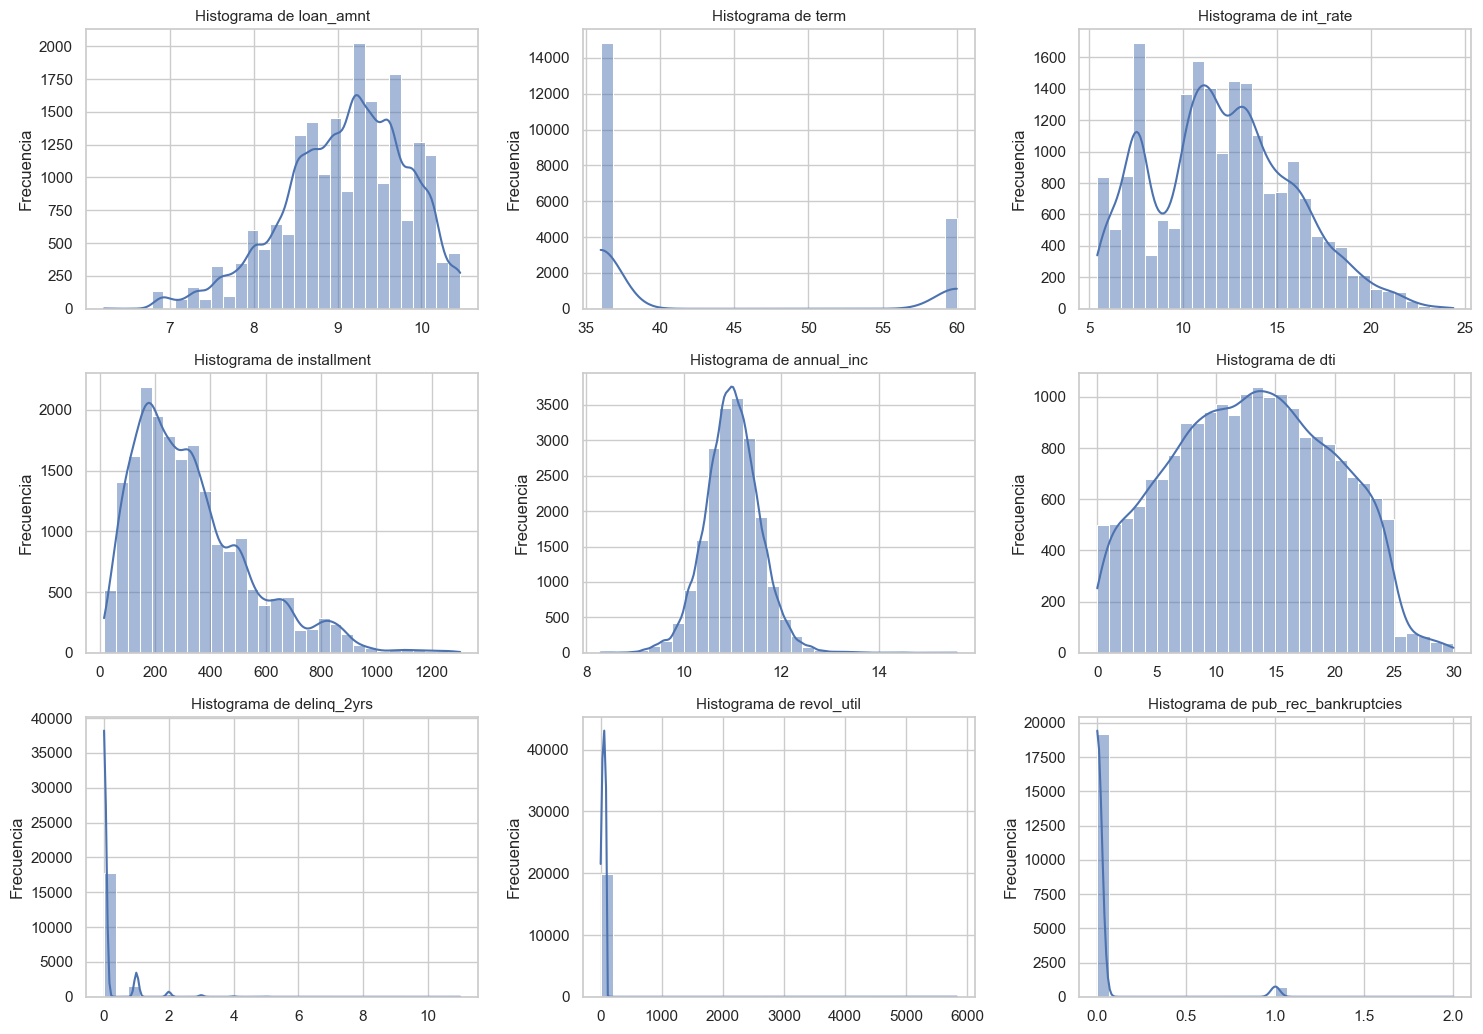


--- Boxplots ---


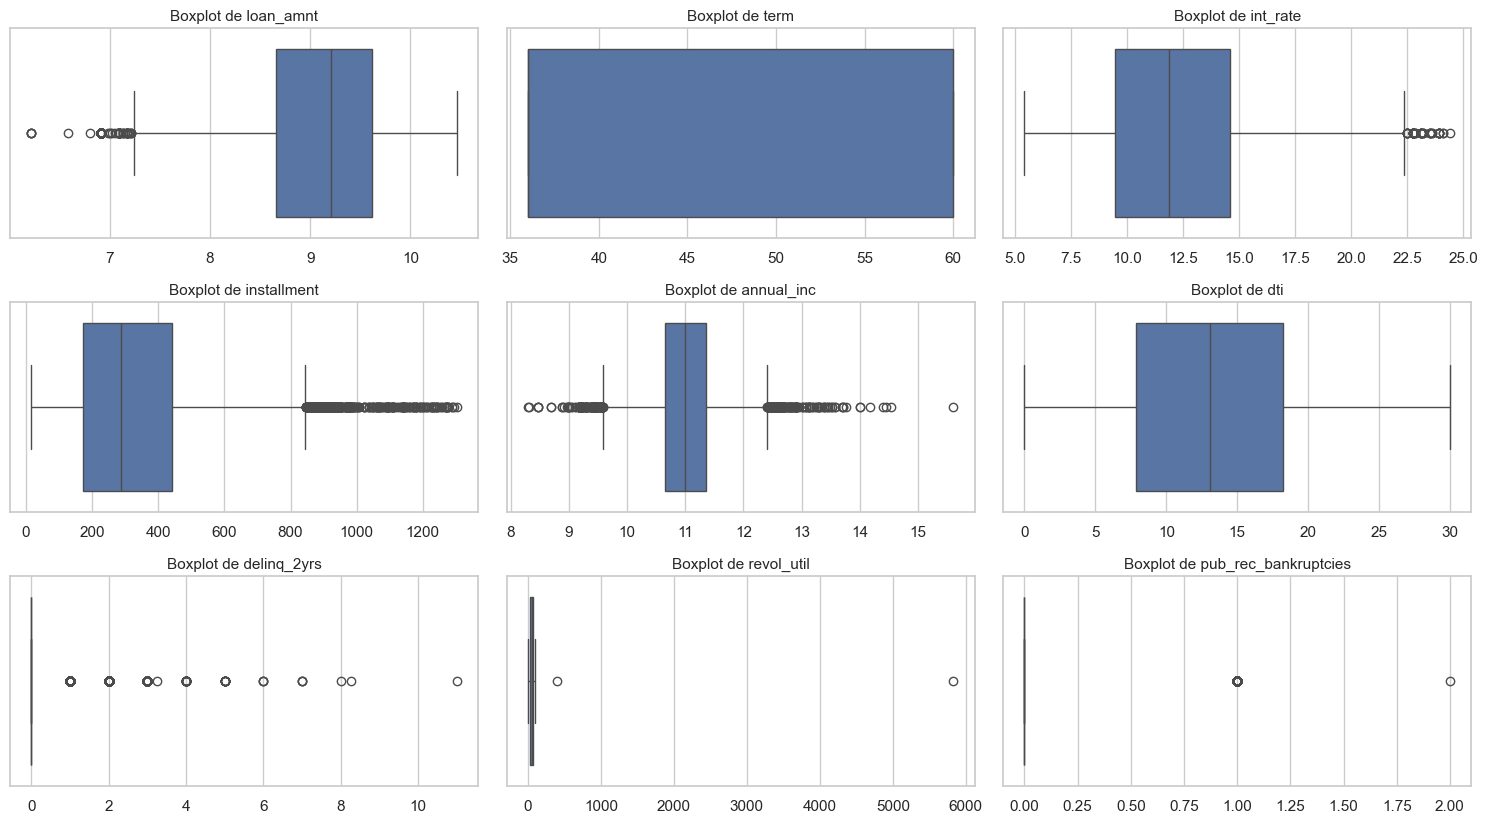


--- Barplots (variables discretas) ---


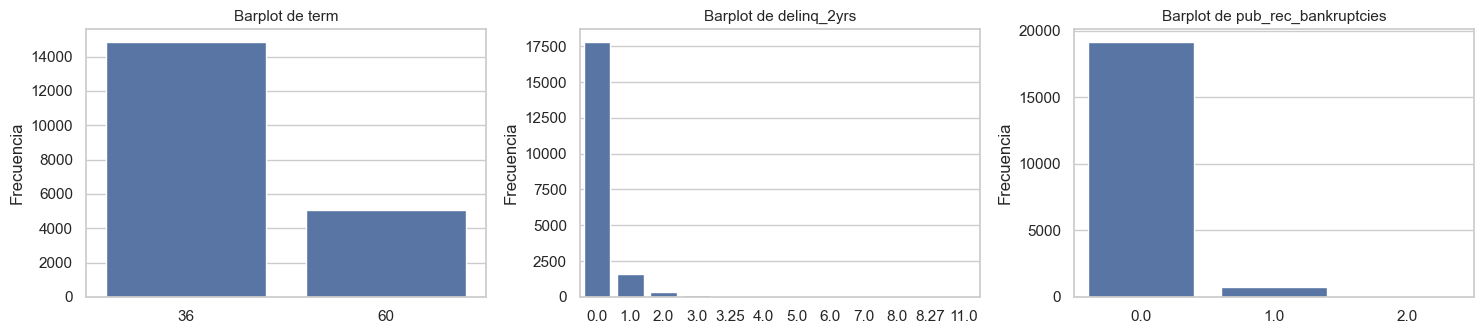

In [31]:
eda_univariado_numericas(df_clas_inter, num_clas, "Dataset de Clasificación")

### 4.2) Categóricas: frecuencias y visualización

In [32]:
def eda_univariado_categoricas(df, cat_clas, nombre_dataset="Dataset"):
    print("\n====================================")
    print(f"Dataset: {nombre_dataset}")
    print("4.2) EDA UNIVARIADO — VARIABLES CATEGÓRICAS")
    print("====================================")

    # Identificar variables categóricas
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    print("\nVariables categóricas analizadas:")
    print(cat_cols)

    if not cat_cols:
        print("No se identificaron variables categóricas.")
        return

    # -------------------------
    # Parámetros visuales automáticos
    # -------------------------
    n_vars = len(cat_cols)
    n_cols = 2 if n_vars <= 6 else 3
    n_rows = math.ceil(n_vars / n_cols)

    # =============================
    # COUNT PLOTS (Top 10)
    # =============================
    print("\n--- Countplots (Top 10 categorías) ---")

    plt.figure(figsize=(6*n_cols, 3.5*n_rows))

    for i, col in enumerate(cat_cols, 1):
        plt.subplot(n_rows, n_cols, i)

        order = df[col].value_counts().head(10).index

        sns.countplot(
            y=col,
            data=df,
            order=order
        )

        plt.title(f"Top 10 categorías — {col}", fontsize=11)
        plt.xlabel("Frecuencia")
        plt.ylabel("")

    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "countplots_top10.png", dpi=300, bbox_inches='tight')
    plt.show()

    # =============================
    # TABLAS DE FRECUENCIAS (Top 10)
    # =============================
    print("\n--- Tablas de frecuencia (Top 10) ---")

    for col in cat_cols:
        print(f"\nVariable categórica: {col}")

        freq_table = (
            df[col]
            .value_counts(dropna=False)
            .to_frame("frecuencia")
        )

        freq_table["frecuencia_relativa"] = (
            freq_table["frecuencia"] / freq_table["frecuencia"].sum()
        ).round(3)

        display(freq_table.head(10))


Dataset: Dataset de Clasificación
4.2) EDA UNIVARIADO — VARIABLES CATEGÓRICAS

Variables categóricas analizadas:
['grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'application_type']

--- Countplots (Top 10 categorías) ---


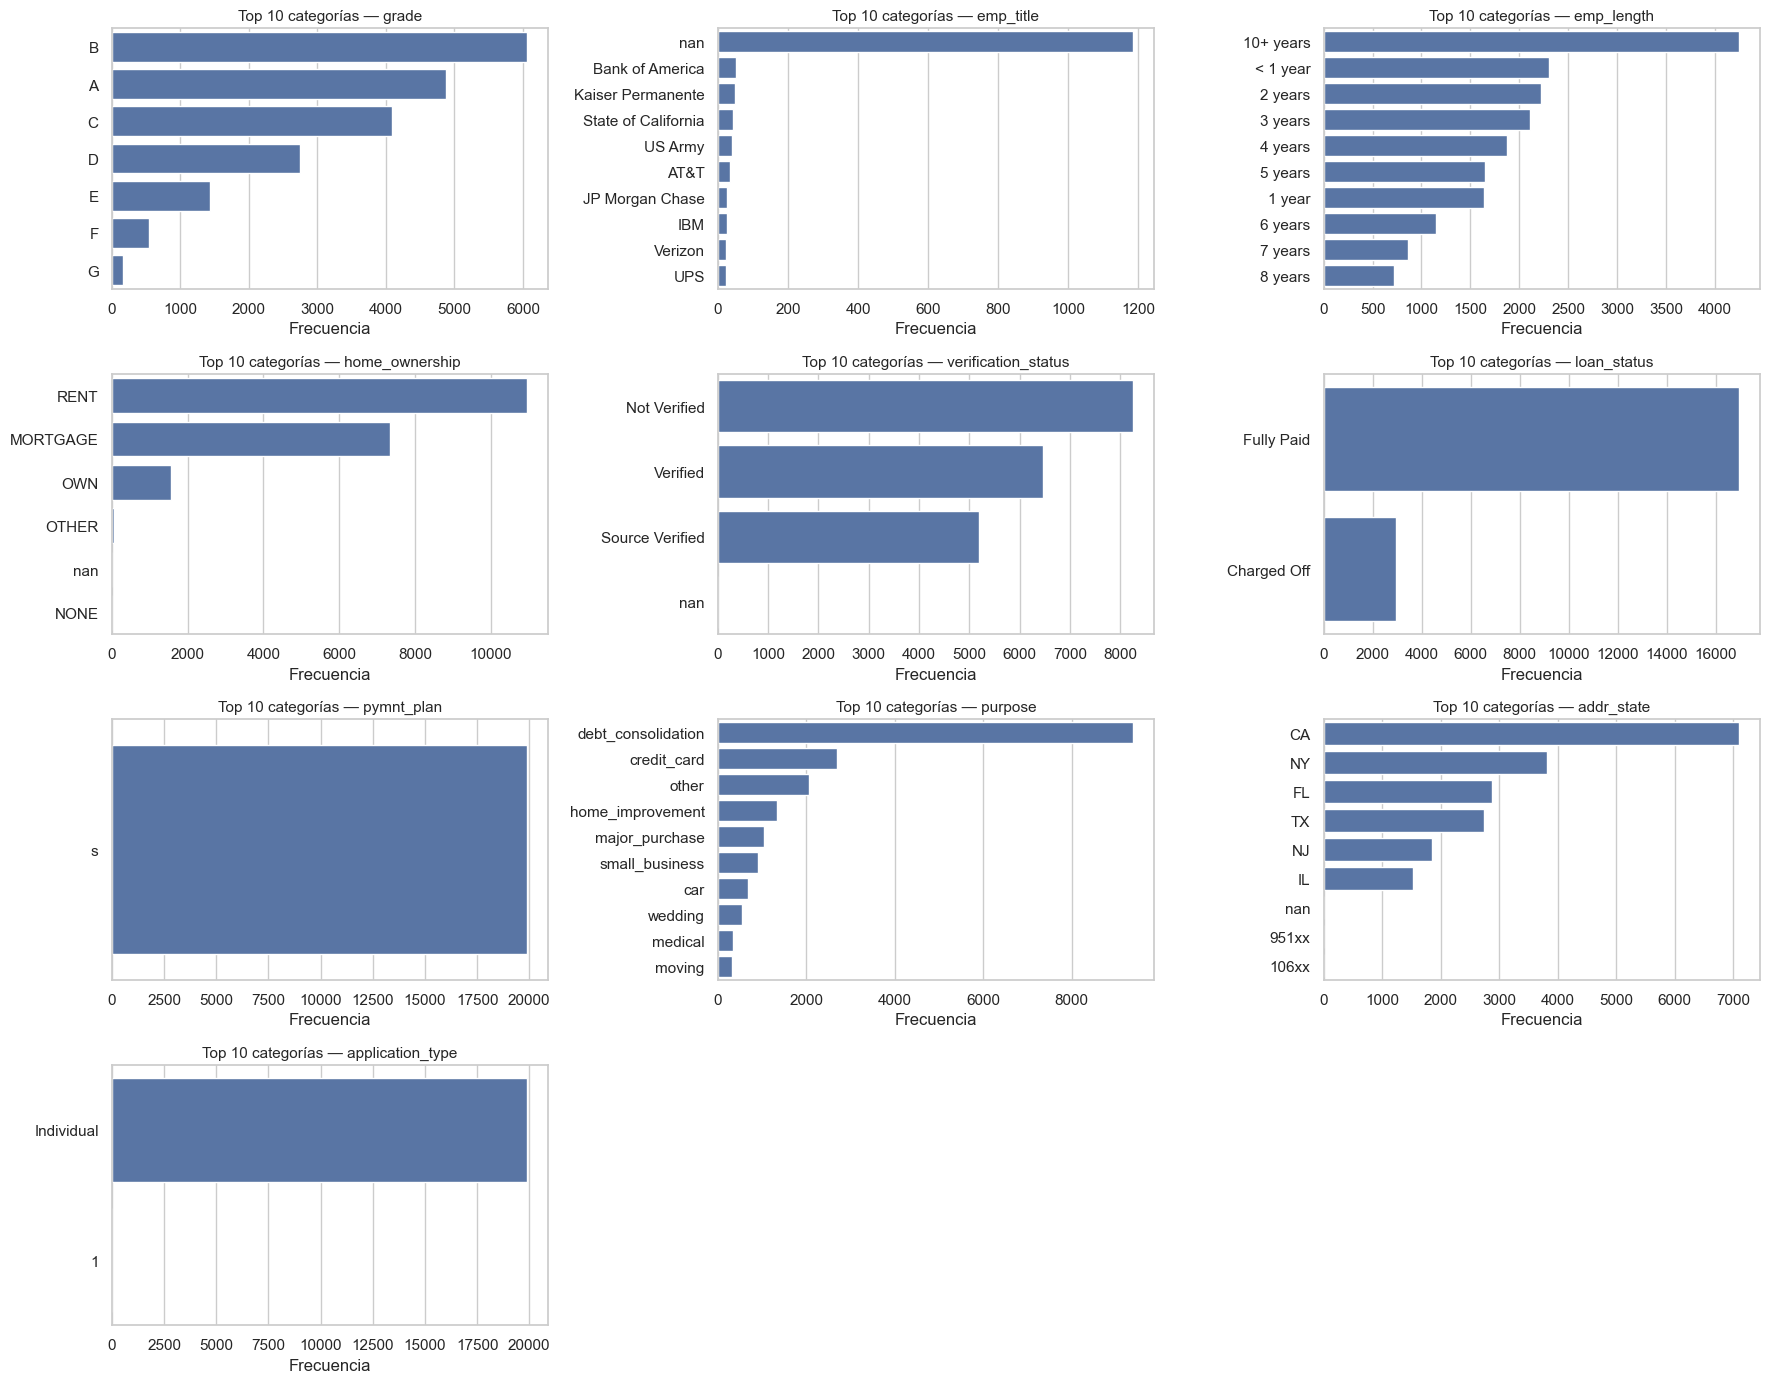


--- Tablas de frecuencia (Top 10) ---

Variable categórica: grade


,frecuencia,frecuencia_relativa
grade,,
B,6065,0.305
A,4875,0.245
C,4087,0.205
D,2748,0.138
E,1434,0.072
F,540,0.027
G,159,0.008



Variable categórica: emp_title


,frecuencia,frecuencia_relativa
emp_title,,
nan,1185,0.060
Bank of America,53,0.003
Kaiser Permanente,50,0.003
State of California,43,0.002
US Army,41,0.002
AT&T,36,0.002
JP Morgan Chase,27,0.001
IBM,26,0.001
Verizon,24,0.001



Variable categórica: emp_length


,frecuencia,frecuencia_relativa
emp_length,,
10+ years,4249,0.213
< 1 year,2304,0.116
2 years,2218,0.111
3 years,2108,0.106
4 years,1871,0.094
5 years,1649,0.083
1 year,1636,0.082
6 years,1151,0.058
7 years,867,0.044



Variable categórica: home_ownership


,frecuencia,frecuencia_relativa
home_ownership,,
RENT,10965,0.551
MORTGAGE,7349,0.369
OWN,1546,0.078
OTHER,44,0.002
nan,3,0.000
NONE,1,0.000



Variable categórica: verification_status


,frecuencia,frecuencia_relativa
verification_status,,
Not Verified,8256,0.415
Verified,6464,0.325
Source Verified,5185,0.260
nan,3,0.000



Variable categórica: loan_status


,frecuencia,frecuencia_relativa
loan_status,,
Fully Paid,16962,0.852
Charged Off,2943,0.148
NaN,3,0.000



Variable categórica: pymnt_plan


,frecuencia,frecuencia_relativa
pymnt_plan,,
s,19908,1.0



Variable categórica: purpose


,frecuencia,frecuencia_relativa
purpose,,
debt_consolidation,9387,0.472
credit_card,2696,0.135
other,2059,0.103
home_improvement,1330,0.067
major_purchase,1048,0.053
small_business,905,0.045
car,687,0.035
wedding,539,0.027
medical,350,0.018



Variable categórica: addr_state


,frecuencia,frecuencia_relativa
addr_state,,
CA,7101,0.357
NY,3813,0.192
FL,2870,0.144
TX,2733,0.137
NJ,1855,0.093
IL,1525,0.077
nan,9,0.000
951xx,1,0.000
106xx,1,0.000



Variable categórica: application_type


,frecuencia,frecuencia_relativa
application_type,,
Individual,19906,1.0
1,2,0.0


In [33]:
eda_univariado_categoricas(df_clas_inter, cat_clas, "Dataset de Clasificación")

### 4.3) Pre procesamiento ex-post

In [45]:
# drop columns 
# categories with low frequency: emp_title y application_type
# numericas: pymnt_plan, delinq_2yrs, revol_util, pub_rec_bankruptcies

df_clas_inter_drop_cols = df_clas_inter.drop(columns=["emp_title", "application_type", "pymnt_plan", "delinq_2yrs", "revol_util", "pub_rec_bankruptcies"])

# converitr term en categorica binaria
# 36 = "30 months" y 60  = "60 months  
df_clas_inter_drop_cols["term"] = df_clas_inter_drop_cols["term"].replace({36: " 36 months", 60: " 60 months"}).astype("category")

num_clas_drop_cols = df_clas_inter_drop_cols.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_clas_drop_cols = df_clas_inter_drop_cols.select_dtypes(include=['object', "category", "bool"]).columns.tolist()
cat_clas_drop_cols.remove(TARGET_CLAS)

# eliminando missings de TARGET_CLAS
df_clas_inter_drop_cols = df_clas_inter_drop_cols.dropna(subset=[TARGET_CLAS])

In [46]:
# guardar df_clas_inter_drop_cols
df_clas_inter_drop_cols.to_csv(INTER_DATA_PATH / "lending_clas_inter_drop_cols.csv", index=False)

In [47]:
df_clas_inter_drop_cols

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti
0,7.783641,36 months,15.96,84.33,C,10+ years,RENT,9.413526,Not Verified,Fully Paid,small_business,IL,8.72
1,9.210440,36 months,13.49,339.31,C,10+ years,RENT,10.803669,Source Verified,Fully Paid,other,CA,20.00
2,8.006701,36 months,18.64,109.43,E,9 years,RENT,10.778977,Source Verified,Fully Paid,car,CA,5.35
3,8.630700,60 months,21.28,152.39,F,4 years,OWN,10.596660,Source Verified,Charged Off,small_business,CA,5.55
4,8.589700,60 months,12.69,121.45,B,< 1 year,RENT,9.615872,Verified,Charged Off,other,TX,18.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19903,8.517393,36 months,9.01,159.03,B,1 year,MORTGAGE,12.429220,Not Verified,Fully Paid,other,NY,10.00
19904,8.160804,36 months,9.96,112.87,B,< 1 year,RENT,9.510519,Not Verified,Fully Paid,educational,FL,16.44
19905,10.126671,36 months,10.59,813.65,C,2 years,RENT,10.778977,Not Verified,Fully Paid,small_business,NY,4.05
19906,8.006701,36 months,10.28,97.20,C,2 years,MORTGAGE,12.206078,Not Verified,Fully Paid,home_improvement,NY,0.00


#### 4.4) EDA univariado ex post pre procesamiento


Dataset: Dataset de Clasificación
4.1) EDA UNIVARIADO — VARIABLES NUMÉRICAS

Variables numéricas analizadas:
['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti']

--- Histogramas ---


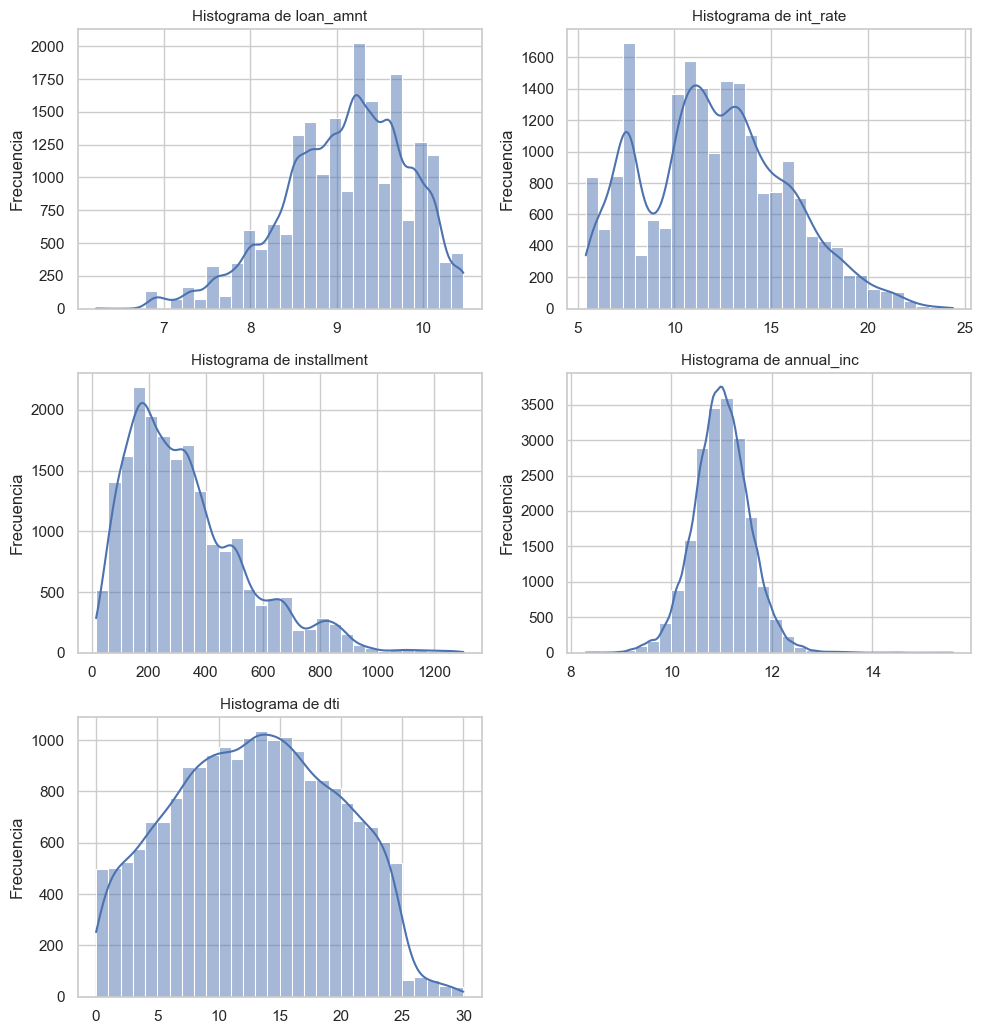


--- Boxplots ---


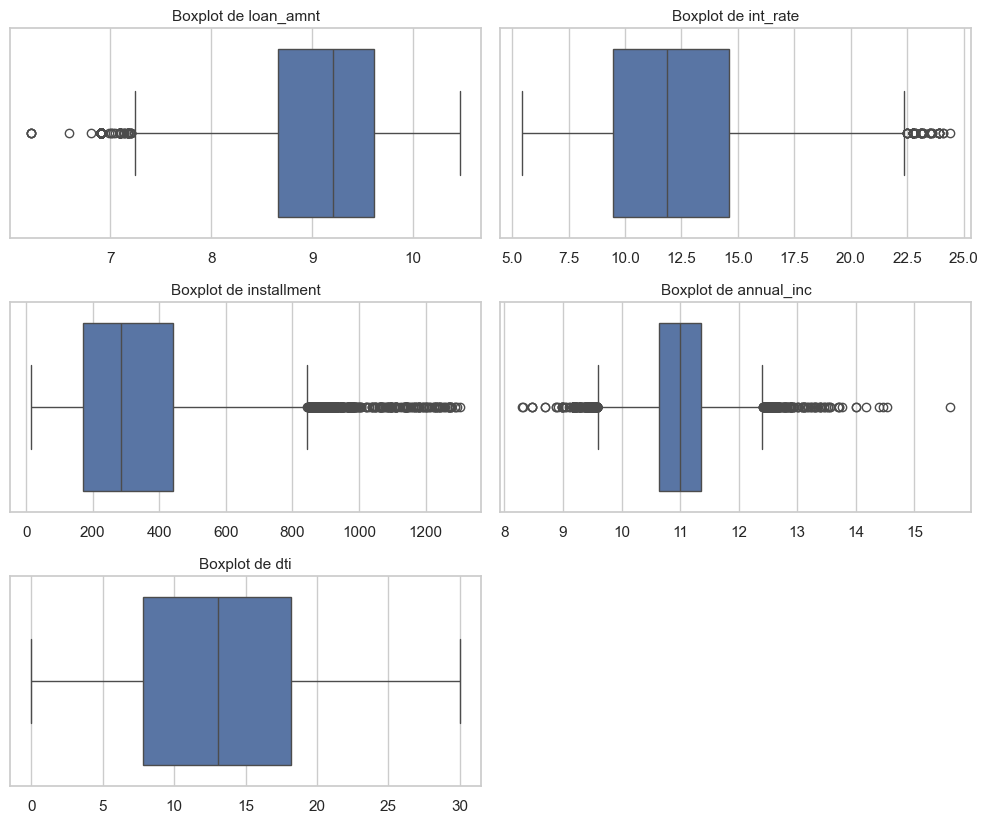


--- Barplots (variables discretas) ---
No se identificaron variables numéricas discretas.


In [48]:
eda_univariado_numericas(df_clas_inter_drop_cols, num_clas_drop_cols, "Dataset de Clasificación")


Dataset: Dataset de Clasificación
4.2) EDA UNIVARIADO — VARIABLES CATEGÓRICAS

Variables categóricas analizadas:
['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state']

--- Countplots (Top 10 categorías) ---


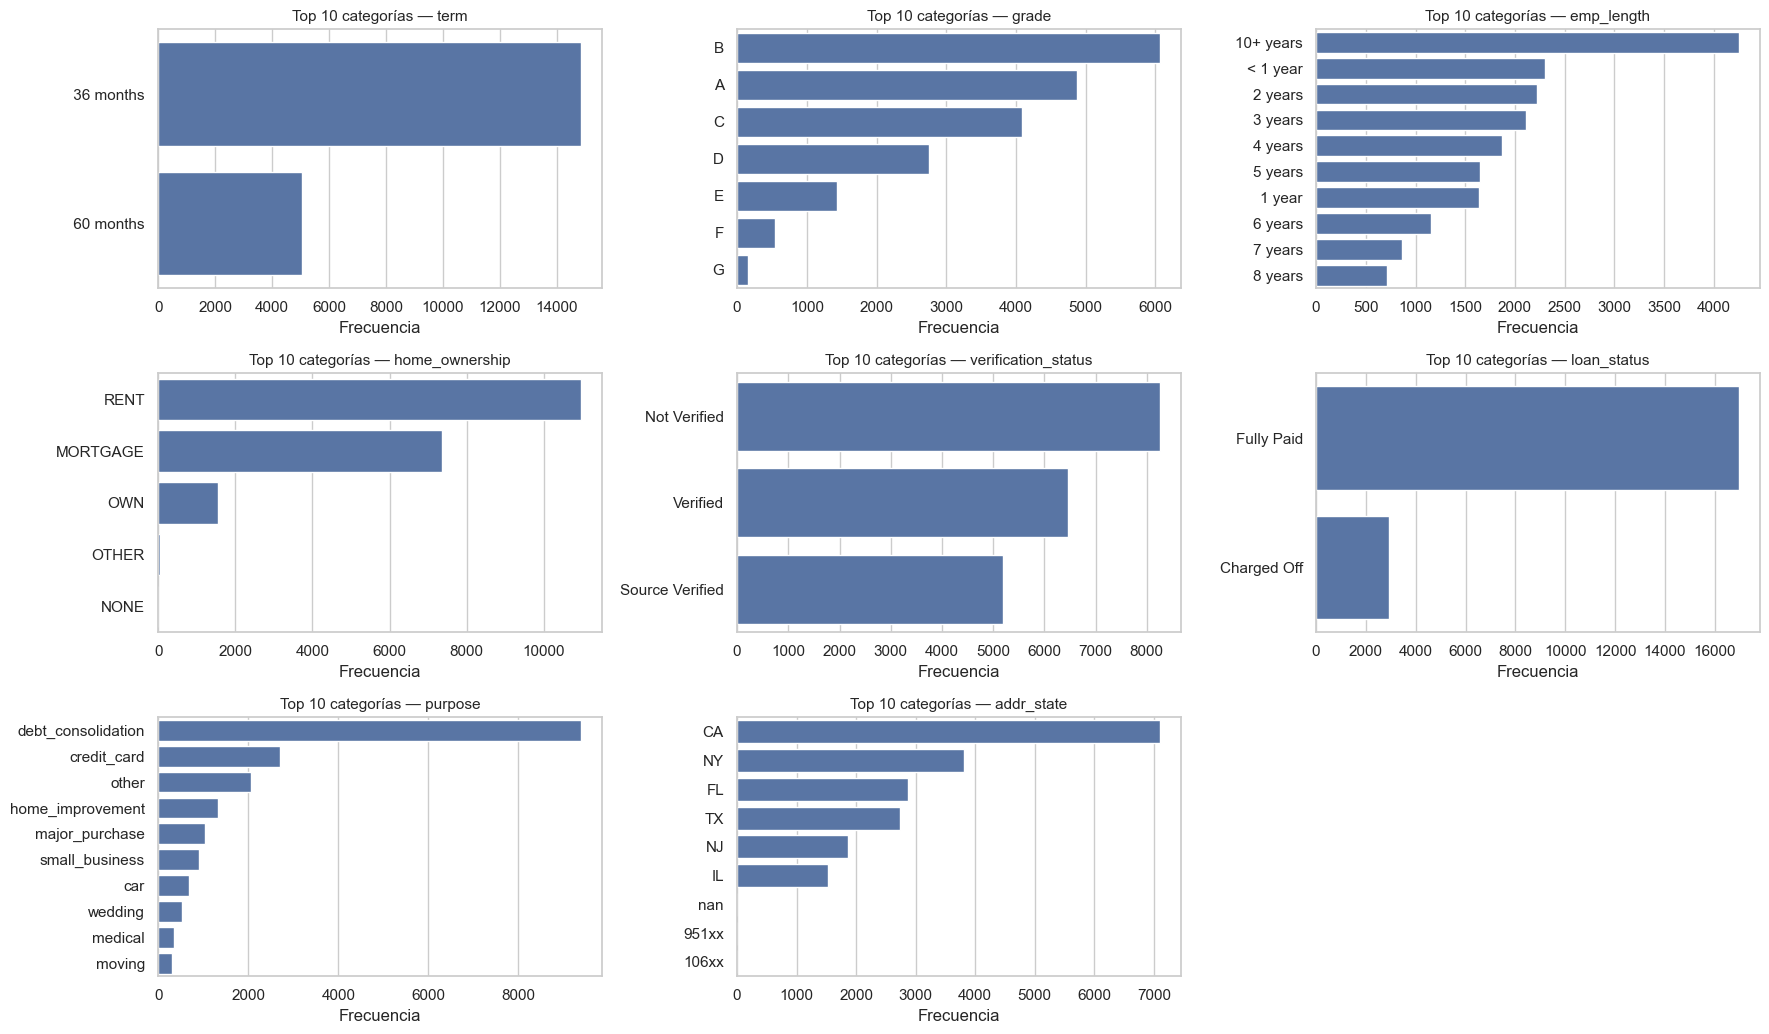


--- Tablas de frecuencia (Top 10) ---

Variable categórica: term


,frecuencia,frecuencia_relativa
term,,
36 months,14850,0.746
60 months,5055,0.254



Variable categórica: grade


,frecuencia,frecuencia_relativa
grade,,
B,6064,0.305
A,4875,0.245
C,4086,0.205
D,2748,0.138
E,1433,0.072
F,540,0.027
G,159,0.008



Variable categórica: emp_length


,frecuencia,frecuencia_relativa
emp_length,,
10+ years,4249,0.213
< 1 year,2304,0.116
2 years,2218,0.111
3 years,2108,0.106
4 years,1871,0.094
5 years,1649,0.083
1 year,1636,0.082
6 years,1151,0.058
7 years,867,0.044



Variable categórica: home_ownership


,frecuencia,frecuencia_relativa
home_ownership,,
RENT,10965,0.551
MORTGAGE,7349,0.369
OWN,1546,0.078
OTHER,44,0.002
NONE,1,0.000



Variable categórica: verification_status


,frecuencia,frecuencia_relativa
verification_status,,
Not Verified,8256,0.415
Verified,6464,0.325
Source Verified,5185,0.260



Variable categórica: loan_status


,frecuencia,frecuencia_relativa
loan_status,,
Fully Paid,16962,0.852
Charged Off,2943,0.148



Variable categórica: purpose


,frecuencia,frecuencia_relativa
purpose,,
debt_consolidation,9387,0.472
credit_card,2696,0.135
other,2059,0.103
home_improvement,1330,0.067
major_purchase,1048,0.053
small_business,905,0.045
car,687,0.035
wedding,539,0.027
medical,350,0.018



Variable categórica: addr_state


,frecuencia,frecuencia_relativa
addr_state,,
CA,7101,0.357
NY,3813,0.192
FL,2870,0.144
TX,2733,0.137
NJ,1855,0.093
IL,1525,0.077
nan,6,0.000
951xx,1,0.000
106xx,1,0.000


In [49]:
eda_univariado_categoricas(df_clas_inter_drop_cols, cat_clas_drop_cols, "Dataset de Clasificación")

## 5) EDA bivariado: variables explicativas vs target

In [50]:
df_clas_inter_drop_cols

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti
0,7.783641,36 months,15.96,84.33,C,10+ years,RENT,9.413526,Not Verified,Fully Paid,small_business,IL,8.72
1,9.210440,36 months,13.49,339.31,C,10+ years,RENT,10.803669,Source Verified,Fully Paid,other,CA,20.00
2,8.006701,36 months,18.64,109.43,E,9 years,RENT,10.778977,Source Verified,Fully Paid,car,CA,5.35
3,8.630700,60 months,21.28,152.39,F,4 years,OWN,10.596660,Source Verified,Charged Off,small_business,CA,5.55
4,8.589700,60 months,12.69,121.45,B,< 1 year,RENT,9.615872,Verified,Charged Off,other,TX,18.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19903,8.517393,36 months,9.01,159.03,B,1 year,MORTGAGE,12.429220,Not Verified,Fully Paid,other,NY,10.00
19904,8.160804,36 months,9.96,112.87,B,< 1 year,RENT,9.510519,Not Verified,Fully Paid,educational,FL,16.44
19905,10.126671,36 months,10.59,813.65,C,2 years,RENT,10.778977,Not Verified,Fully Paid,small_business,NY,4.05
19906,8.006701,36 months,10.28,97.20,C,2 years,MORTGAGE,12.206078,Not Verified,Fully Paid,home_improvement,NY,0.00


### 5.2 Para Clasificación

#### 5.2.1) Numéricas vs Target

In [51]:
def eda_bivariado_numericas_vs_target_clas(df, num_cols, target, q=5):
    """
    Análisis bivariado completo de variables numéricas vs target para clasificación.   
    Args:
        df: DataFrame a analizar
        num_cols: Lista de columnas numéricas
        target: Variable objetivo (categórica binaria)
        q: Número de buckets/quintiles
    """
    # Configuración inicial
    target_classes = df[target].unique()
    print(f"\n{'='*60}")
    print(f"EDA BIVARIADO: NUMÉRICAS vs TARGET ({target})")
    print(f"{'='*60}")
    print(f"Clases del target: {target_classes}")
    print(f"Variables numéricas: {num_cols}")
    
    # Crear variable binaria para cálculos
    df_temp = df.copy()
    df_temp['target_bin'] = (df_temp[target] == target_classes[0]).astype(int)
    
    # Parámetros visuales
    n_vars = len(num_cols)
    n_cols_plot = min(3, n_vars) if n_vars > 1 else 1
    n_rows_plot = math.ceil(n_vars / n_cols_plot)
    
    # =========================================
    # 1. BOXPLOTS POR CLASE (grid)
    # =========================================
    print("\n--- 1. Boxplots por clase ---")
    
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(6*n_cols_plot, 4*n_rows_plot))
    
    # Convertir axes a array 1D siempre
    if n_vars == 1:
        axes = [axes]
    else:
        axes = np.array(axes).flatten()
    
    for i, col in enumerate(num_cols):
        sns.boxplot(data=df_temp, x=target, y=col, ax=axes[i])
        axes[i].set_title(f'{col} por {target}', fontsize=11)
        axes[i].set_xlabel(target)
        axes[i].set_ylabel(col)
    
    # Ocultar ejes vacíos
    for j in range(len(num_cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "bivariado_boxplots_por_clase.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # =========================================
    # 2. TASAS POR BUCKETS (grid)
    # =========================================
    print("\n--- 2. Tasa del target por buckets ---")
    
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(6*n_cols_plot, 4*n_rows_plot))
    
    # Convertir axes a array 1D siempre
    if n_vars == 1:
        axes = [axes]
    else:
        axes = np.array(axes).flatten()
    
    tasa_global = df_temp['target_bin'].mean()
    
    tablas_resumen = []
    
    for i, col in enumerate(num_cols):
        df_col = df_temp[[col, 'target_bin']].dropna()
        
        if df_col.empty:
            axes[i].set_visible(False)
            continue
        
        # Intentar crear buckets, si falla usar menos buckets o saltear
        try:
            df_col['bucket'] = pd.qcut(df_col[col], q=q, duplicates='drop')
            n_buckets = df_col['bucket'].nunique()
            
            if n_buckets < 2:
                print(f"  ⚠️ {col}: Solo {n_buckets} bucket(s), saltando...")
                axes[i].set_visible(False)
                continue
                
        except ValueError as e:
            print(f"  ⚠️ {col}: No se pudo crear buckets - {e}")
            axes[i].set_visible(False)
            continue
        
        stats = df_col.groupby('bucket').agg(
            n=('target_bin', 'count'),
            tasa_target=('target_bin', 'mean')
        ).round(4).reset_index()
        
        stats['variable'] = col
        tablas_resumen.append(stats)
        
        # Gráfico
        axes[i].bar(range(len(stats)), stats['tasa_target'], color='steelblue', edgecolor='black')
        axes[i].axhline(y=tasa_global, color='red', linestyle='--', label='Tasa global')
        axes[i].set_title(f'Tasa de {target_classes[0]} por quintiles de {col}', fontsize=10)
        axes[i].set_xlabel(f'Quintiles de {col}')
        axes[i].set_ylabel(f'Tasa')
        axes[i].set_xticks(range(len(stats)))
        axes[i].set_xticklabels([str(b)[:15] for b in stats['bucket']], rotation=45, ha='right', fontsize=8)
        axes[i].legend(fontsize=8)
    
    # Ocultar ejes vacíos
    for j in range(len(num_cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "bivariado_tasas_por_buckets.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Mostrar tablas de resumen
    print("\n--- Tablas de tasas por buckets ---")
    if not tablas_resumen:
        print("No se generaron tablas de resumen.")
    else:
        for tabla in tablas_resumen:
            if len(tabla) > 0:
                var = tabla['variable'].iloc[0]
                print(f"\n{var}:")
                display(tabla[['bucket', 'n', 'tasa_target']])
    
    # =========================================
    # 3. ANÁLISIS DE TENDENCIA
    # =========================================
    print("\n--- 3. Análisis de tendencia (monotonía) ---")
    
    tendencias = []
    for col in num_cols:
        df_col = df_temp[[col, 'target_bin']].dropna()
        
        if df_col.empty:
            continue
        
        try:
            df_col['bucket'] = pd.qcut(df_col[col], q=q, duplicates='drop')
            
            if df_col['bucket'].nunique() < 2:
                continue
                
            tasas = df_col.groupby('bucket')['target_bin'].mean().values
            
            if len(tasas) < 2:
                continue
                
            diffs = np.diff(tasas)
            
            if np.all(diffs >= 0):
                tendencia = 'Creciente ↑'
            elif np.all(diffs <= 0):
                tendencia = 'Decreciente ↓'
            else:
                tendencia = 'No monótona ↕'
            
            tendencias.append({
                'variable': col,
                'tendencia': tendencia,
                'tasas_por_bucket': np.round(tasas, 4).tolist()
            })
        except ValueError:
            continue
    
    if tendencias:
        tendencias_df = pd.DataFrame(tendencias)
        display(tendencias_df)
    else:
        print("No se pudo calcular tendencias para ninguna variable.")



EDA BIVARIADO: NUMÉRICAS vs TARGET (loan_status)
Clases del target: ['Fully Paid' 'Charged Off']
Variables numéricas: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti']

--- 1. Boxplots por clase ---


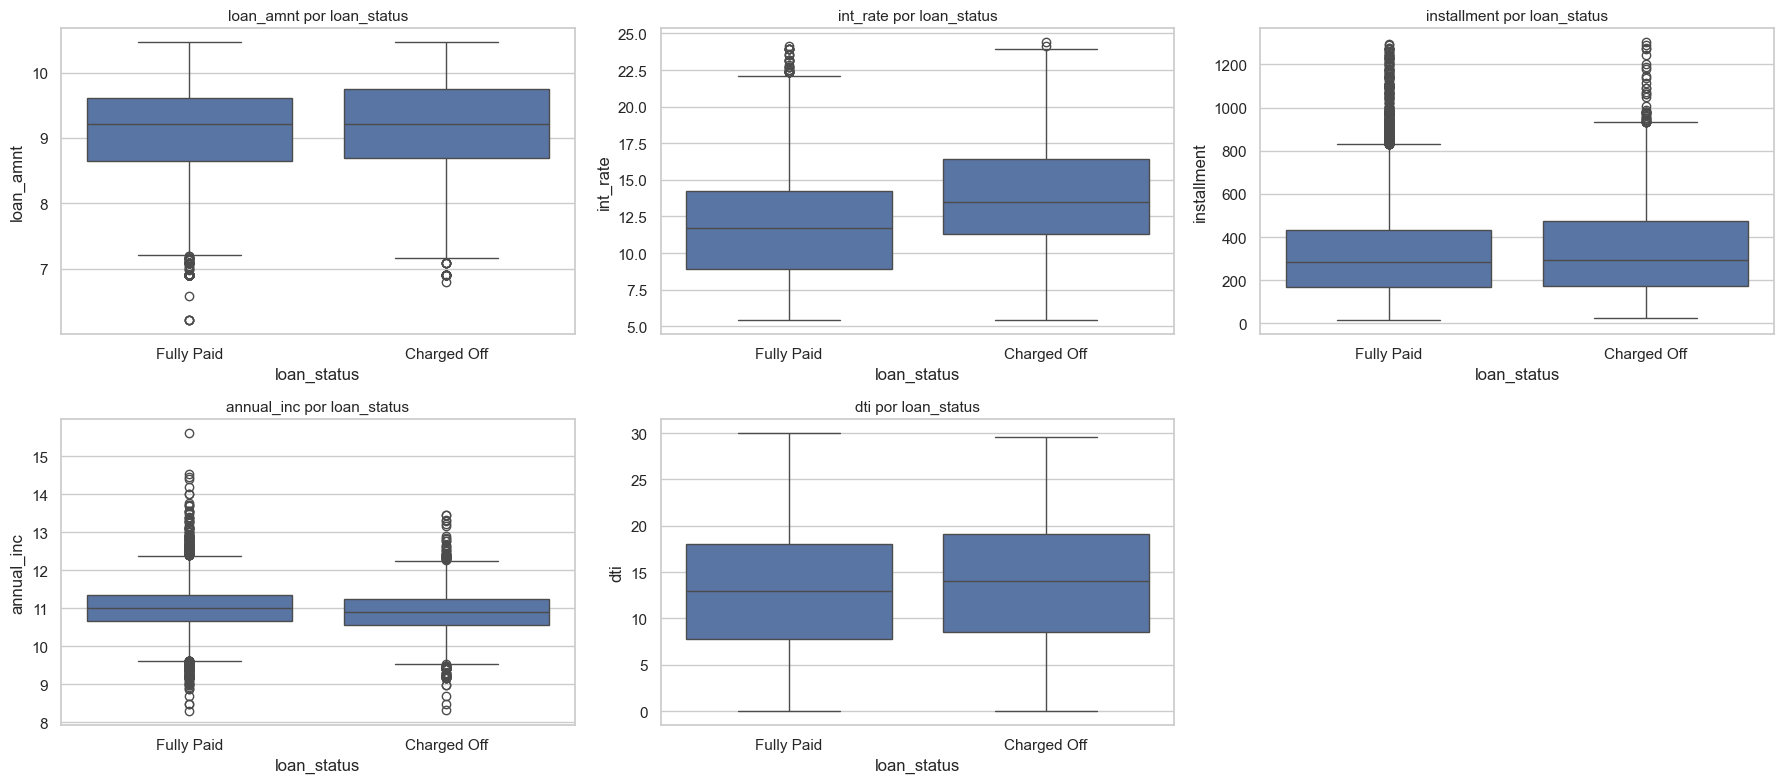


--- 2. Tasa del target por buckets ---


C:\Users\leydi\AppData\Local\Temp\ipykernel_49216\3238143884.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_col.groupby('bucket').agg(
C:\Users\leydi\AppData\Local\Temp\ipykernel_49216\3238143884.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_col.groupby('bucket').agg(
C:\Users\leydi\AppData\Local\Temp\ipykernel_49216\3238143884.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats 

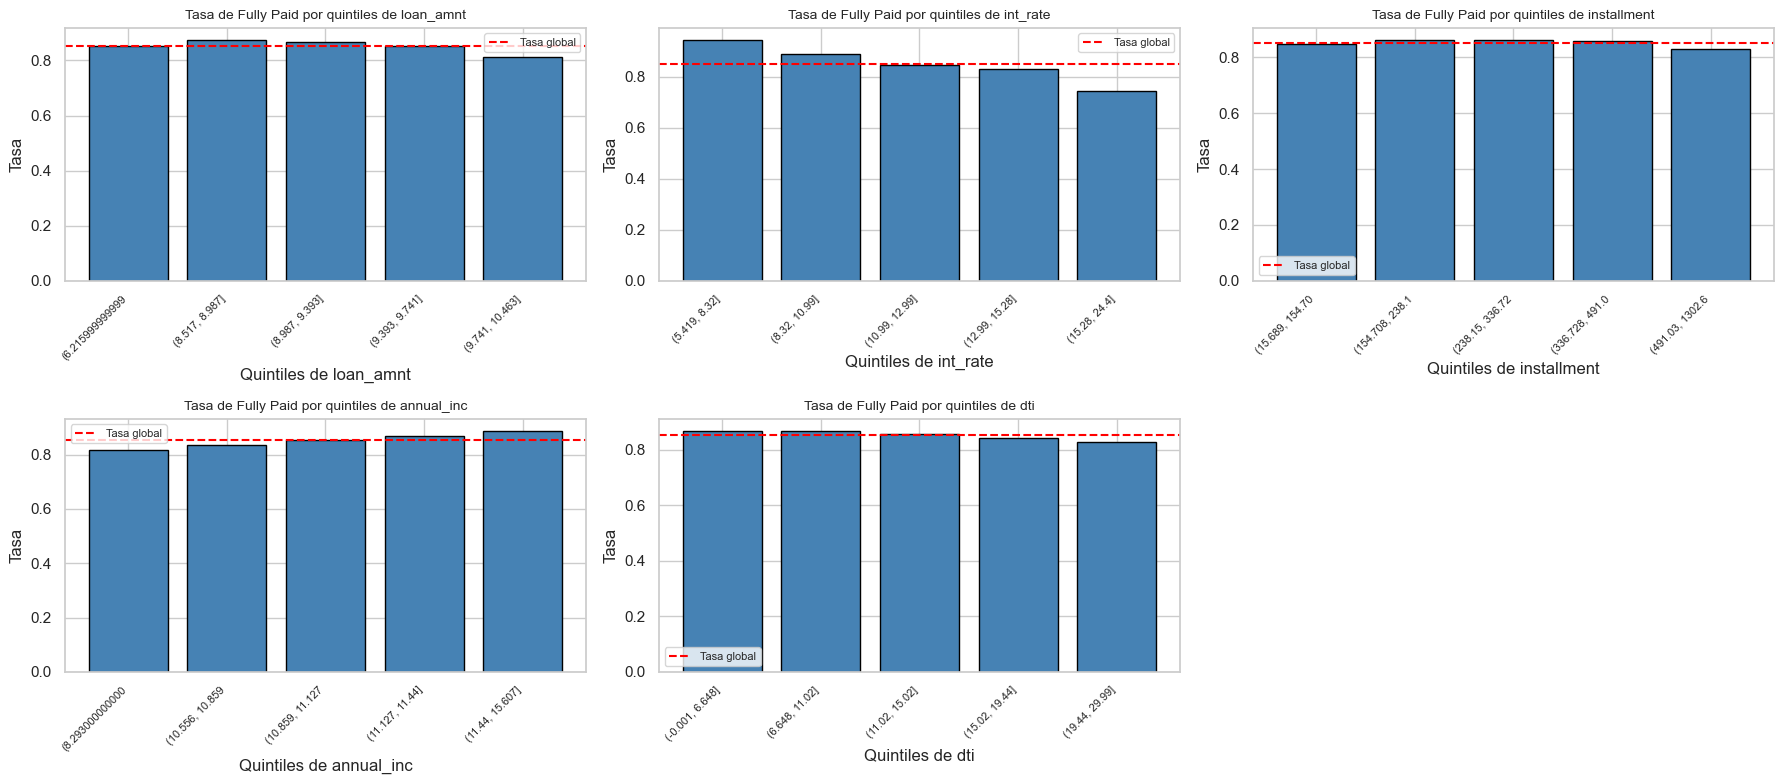


--- Tablas de tasas por buckets ---

loan_amnt:


,bucket,n,tasa_target
0,"(6.215999999999999, 8.517]",4576,0.8521
1,"(8.517, 8.987]",4000,0.8748
2,"(8.987, 9.393]",4436,0.8677
3,"(9.393, 9.741]",2986,0.8520
4,"(9.741, 10.463]",3907,0.8116



int_rate:


,bucket,n,tasa_target
0,"(5.419, 8.32]",3993,0.9454
1,"(8.32, 10.99]",4058,0.8879
2,"(10.99, 12.99]",4040,0.8483
3,"(12.99, 15.28]",3897,0.8314
4,"(15.28, 24.4]",3917,0.7447



installment:


,bucket,n,tasa_target
0,"(15.689, 154.708]",3981,0.8488
1,"(154.708, 238.15]",3986,0.8628
2,"(238.15, 336.728]",3976,0.8624
3,"(336.728, 491.03]",3983,0.8584
4,"(491.03, 1302.69]",3979,0.8283



annual_inc:


,bucket,n,tasa_target
0,"(8.293000000000001, 10.556]",3982,0.8154
1,"(10.556, 10.859]",4085,0.8350
2,"(10.859, 11.127]",3914,0.8544
3,"(11.127, 11.44]",3948,0.8690
4,"(11.44, 15.607]",3976,0.8876



dti:


,bucket,n,tasa_target
0,"(-0.001, 6.648]",3981,0.8659
1,"(6.648, 11.02]",3984,0.8675
2,"(11.02, 15.02]",3989,0.8566
3,"(15.02, 19.44]",3978,0.8421
4,"(19.44, 29.99]",3973,0.8286



--- 3. Análisis de tendencia (monotonía) ---


C:\Users\leydi\AppData\Local\Temp\ipykernel_49216\3238143884.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tasas = df_col.groupby('bucket')['target_bin'].mean().values
C:\Users\leydi\AppData\Local\Temp\ipykernel_49216\3238143884.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tasas = df_col.groupby('bucket')['target_bin'].mean().values
C:\Users\leydi\AppData\Local\Temp\ipykernel_49216\3238143884.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

,variable,tendencia,tasas_por_bucket
0,loan_amnt,No monótona ↕,"[0.8521, 0.8748, 0.8677, 0.852, 0.8116]"
1,int_rate,Decreciente ↓,"[0.9454, 0.8879, 0.8483, 0.8314, 0.7447]"
2,installment,No monótona ↕,"[0.8488, 0.8628, 0.8624, 0.8584, 0.8283]"
3,annual_inc,Creciente ↑,"[0.8154, 0.835, 0.8544, 0.869, 0.8876]"
4,dti,No monótona ↕,"[0.8659, 0.8675, 0.8566, 0.8421, 0.8286]"


In [52]:
# Aplicar análisis de numéricas vs target para clasificación

eda_bivariado_numericas_vs_target_clas(df_clas_inter_drop_cols, num_clas_drop_cols, TARGET_CLAS)

#### 5.1.2) Categóricas vs Target

In [53]:
def analisis_categorias_vs_target(df, cat_cols, target, top_k=15):
    """
    Qué hacer: medir la señal del target (tasa) y la cobertura (n) por categoría.
    Por qué: priorizar grupos con poder predictivo y descartar los de baja evidencia.
    Orden/función:
        1. Preparar tasa global del target y contenedores de resultados.
        2. Para cada columna categórica, calcular tasas y frecuencias (groupby).
        3. Graficar todo en dos lienzos agrupados (tasa vs. registros).
        4. Dejar evidencia tabular y alertas de categorías raras.
    Evidencia a dejar: figuras guardadas en graphs, tablas mostradas en notebook y advertencias impresas.
    """
    target_classes = df[target].dropna().unique()
    if target_classes.size == 0:
        print("Target sin clases válidas.")
        return
    foco = target_classes[0]
    global_rate = (df[target] == foco).mean()

    tasa_por_col = {}
    registros_por_col = {}
    columnas_validas = []

    for col in cat_cols:
        df_temp = df[[col, target]].dropna()
        if df_temp.empty:
            print(f"Sin datos para {col}")
            continue
        df_temp['target_bin'] = (df_temp[target] == foco).astype(int)

        tasas = (
            df_temp.groupby(col)['target_bin']
            .agg(['mean', 'count'])
            .rename(columns={'mean': 'tasa_target', 'count': 'n'})
            .sort_values('tasa_target', ascending=False)
            .reset_index()
        )
        tasa_por_col[col] = tasas

        conteos = (
            df_temp.groupby(col)['target_bin']
            .size()
            .reset_index(name='n')
            .sort_values('n', ascending=False)
            .reset_index(drop=True)
        )
        conteos['pct_total'] = (conteos['n'] / conteos['n'].sum() * 100).round(2)
        registros_por_col[col] = conteos
        columnas_validas.append(col)

    if not columnas_validas:
        print("No se generó evidencia para las columnas solicitadas.")
        return

    n_plots = len(columnas_validas)
    n_cols_plot = 2 if n_plots <= 4 else 3
    n_rows_plot = math.ceil(n_plots / n_cols_plot)

    # Figura 1: tasas por categoría
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(6*n_cols_plot, 4*n_rows_plot))
    axes = np.array(axes).flatten() if n_plots > 1 else [axes]
    for idx, col in enumerate(columnas_validas):
        top_stats = tasa_por_col[col].head(top_k)
        axes[idx].bar(range(len(top_stats)), top_stats['tasa_target'], color='steelblue', edgecolor='black')
        axes[idx].axhline(global_rate, color='red', linestyle='--', label=f"Tasa global: {global_rate:.3f}")
        axes[idx].set_title(f"Tasa {foco} — {col}", fontsize=10)
        axes[idx].set_ylabel('Tasa')
        axes[idx].set_xticks(range(len(top_stats)))
        axes[idx].set_xticklabels(top_stats[col].astype(str), rotation=45, ha='right')
        axes[idx].legend(fontsize=8)
    for j in range(len(columnas_validas), len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "bivariado_tasa_por_categoria.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Figura 2: registros por categoría
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(6*n_cols_plot, 4*n_rows_plot))
    axes = np.array(axes).flatten() if n_plots > 1 else [axes]
    for idx, col in enumerate(columnas_validas):
        top_counts = registros_por_col[col].head(top_k)
        axes[idx].bar(range(len(top_counts)), top_counts['n'], color='mediumpurple', edgecolor='black')
        axes[idx].set_title(f"Registros — {col}", fontsize=10)
        axes[idx].set_ylabel('n')
        axes[idx].set_xticks(range(len(top_counts)))
        axes[idx].set_xticklabels(top_counts[col].astype(str), rotation=45, ha='right')
    for j in range(len(columnas_validas), len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.savefig(GRAPHS_PATH_LENDING / "bivariado_registros_por_categoria.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Evidencia tabular
    for col in columnas_validas:
        print(f"\n{'='*50}")
        print(f"Tasa de '{foco}' por categoría: {col}")
        print(f"{'='*50}")
        display(tasa_por_col[col])

        print(f"\n{'-'*50}")
        print(f"Registros por categoría: {col}")
        print(f"{'-'*50}")
        conteos = registros_por_col[col]
        display(conteos)
        raras = conteos[conteos['pct_total'] < 1]
        if not raras.empty:
            print(f"⚠️ Categorías raras (<1%): {len(raras)} de {len(conteos)}")
            display(raras)

    print(f"\n✅ Gráficos guardados en: {GRAPHS_PATH_LENDING}")

C:\Users\leydi\AppData\Local\Temp\ipykernel_49216\1833504749.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby(col)['target_bin']
C:\Users\leydi\AppData\Local\Temp\ipykernel_49216\1833504749.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby(col)['target_bin']


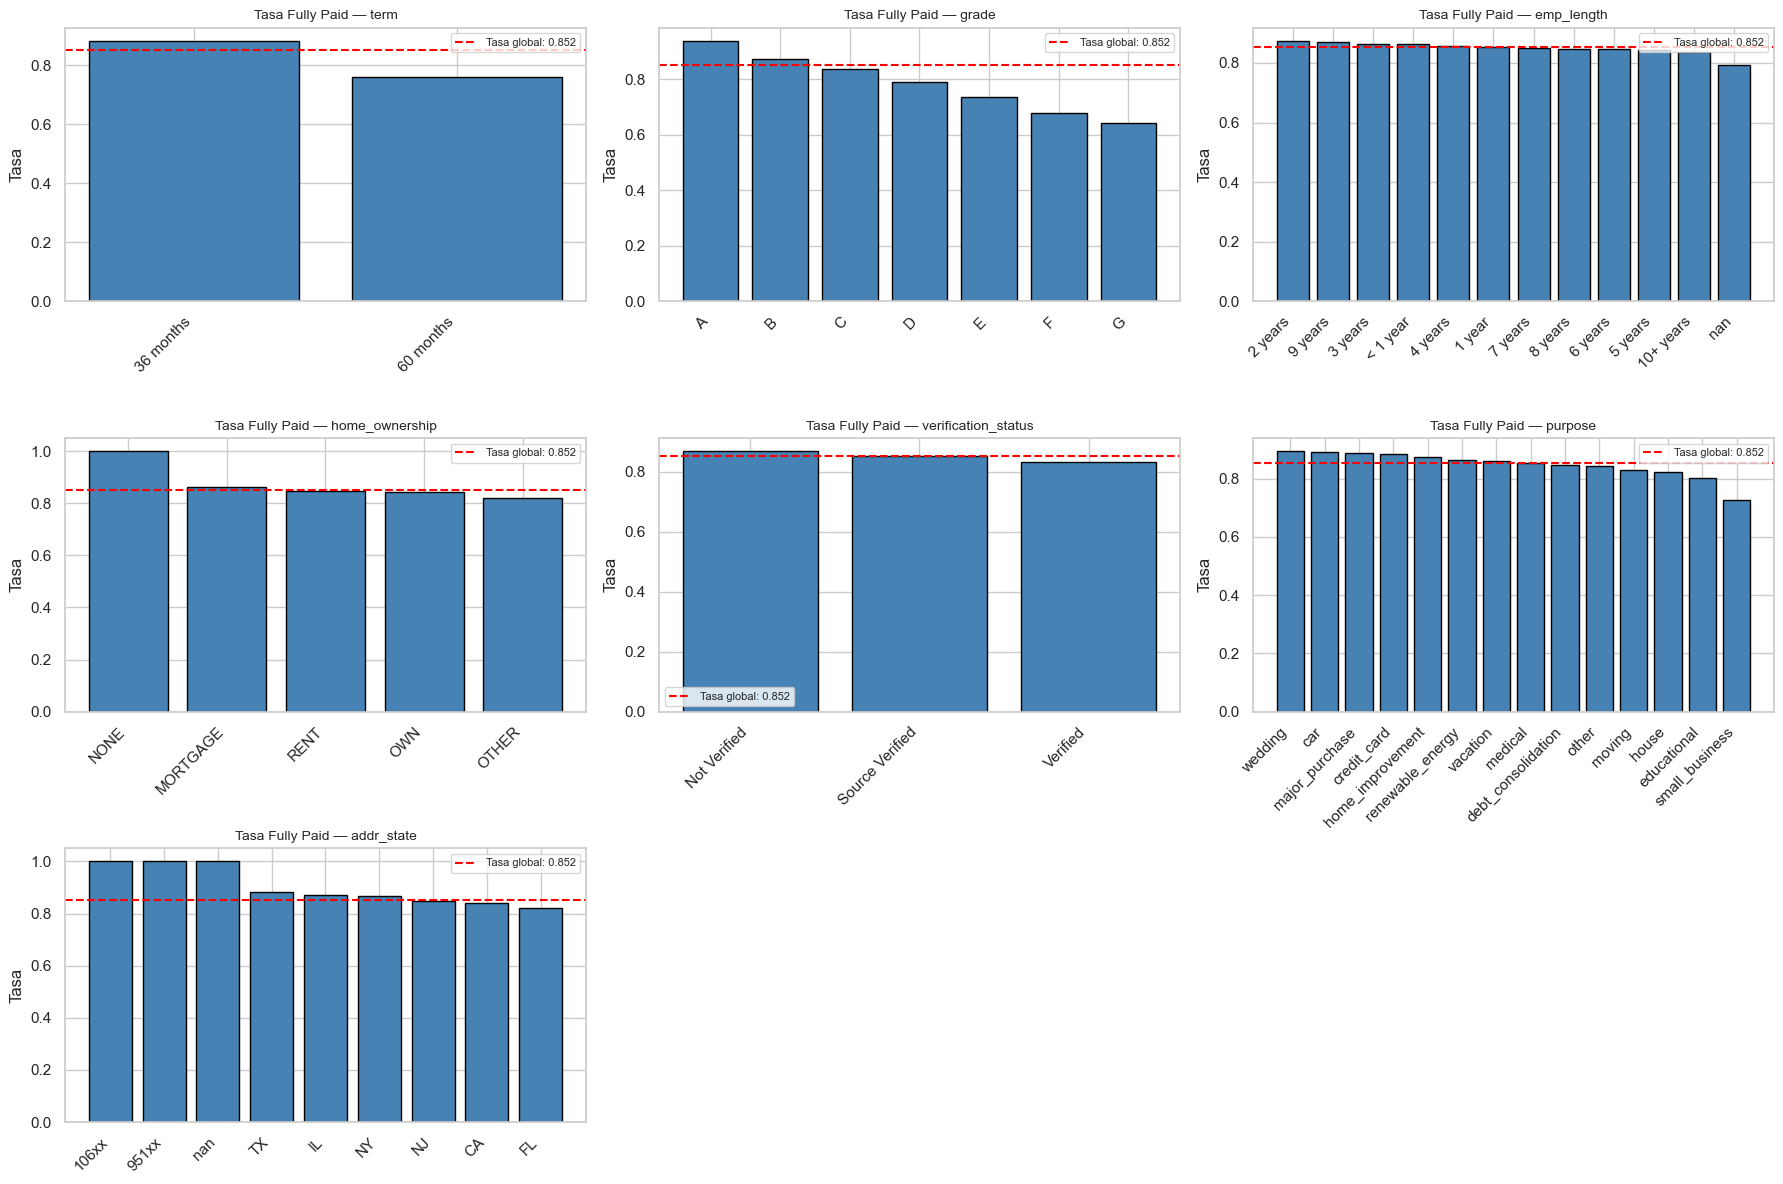

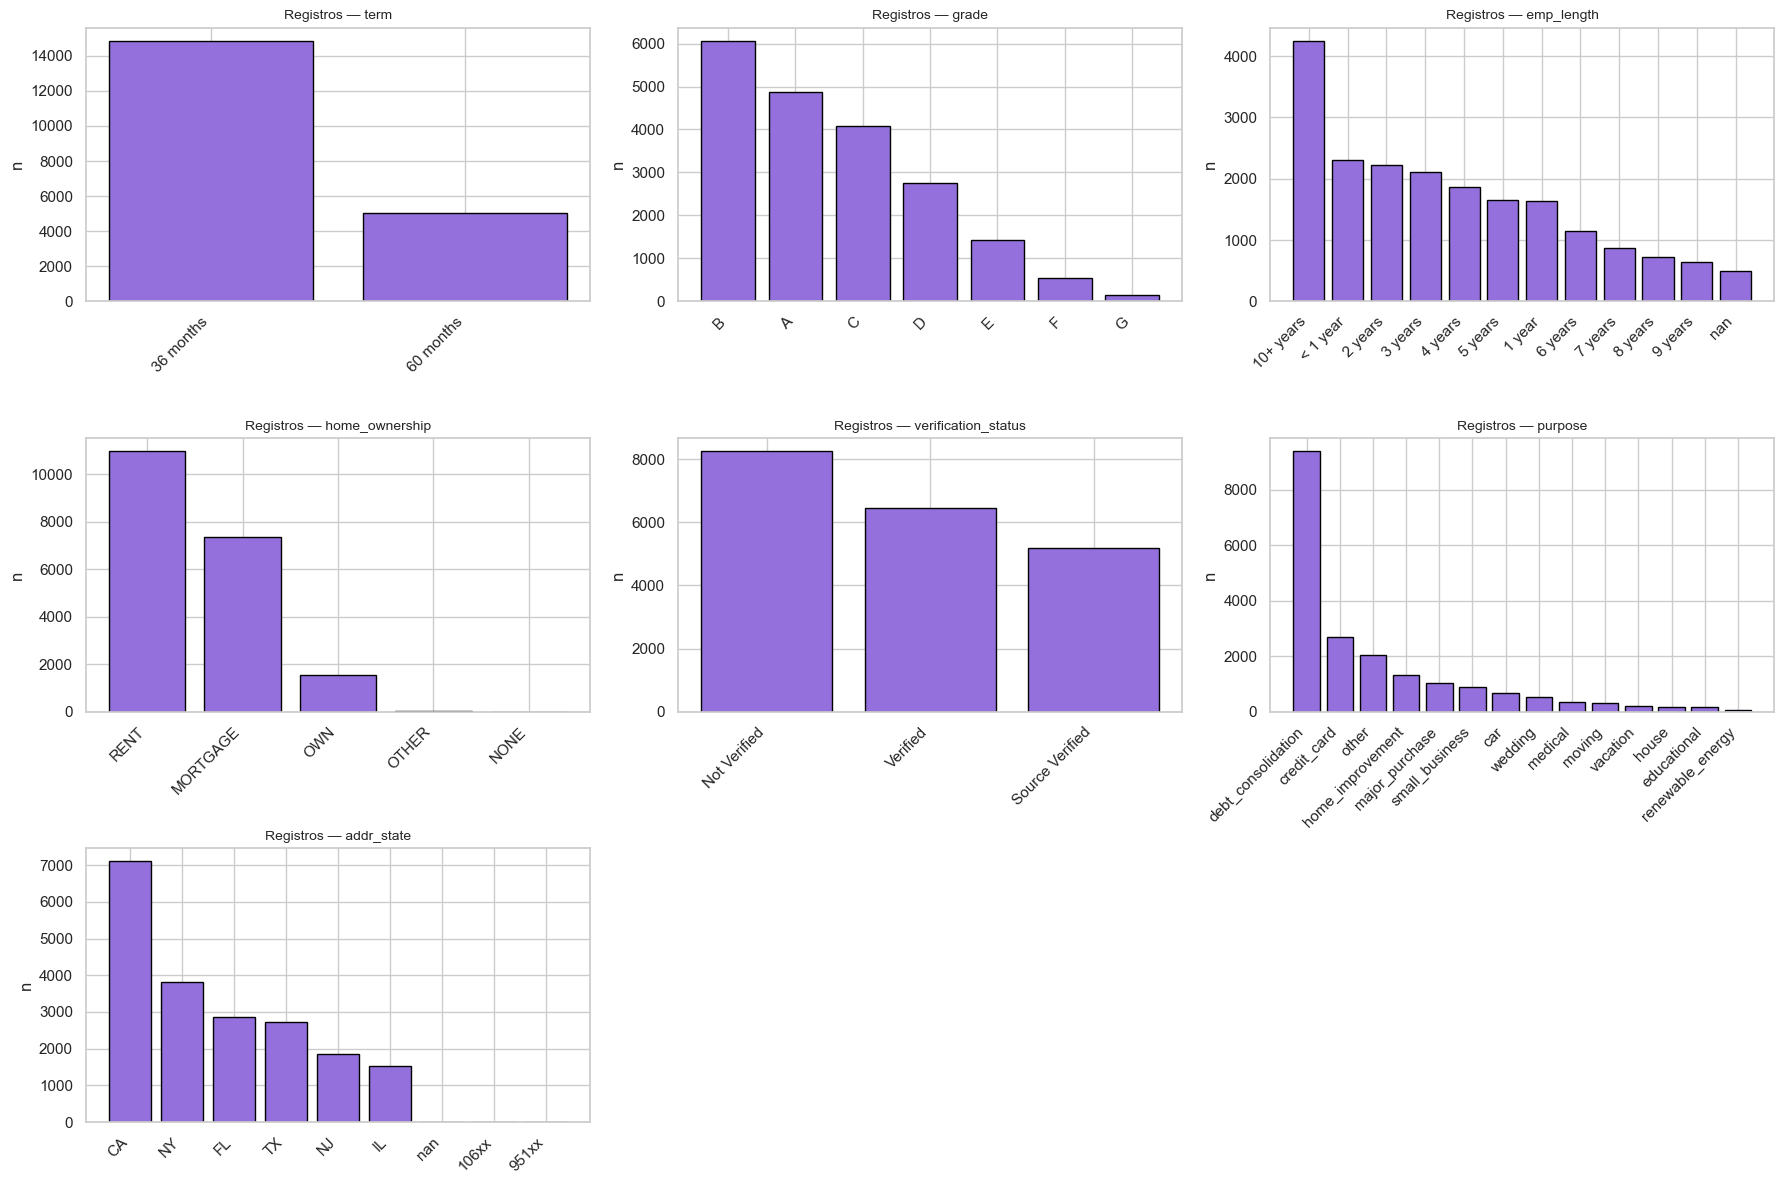


Tasa de 'Fully Paid' por categoría: term


,term,tasa_target,n
0,36 months,0.883636,14850
1,60 months,0.759644,5055



--------------------------------------------------
Registros por categoría: term
--------------------------------------------------


,term,n,pct_total
0,36 months,14850,74.6
1,60 months,5055,25.4



Tasa de 'Fully Paid' por categoría: grade


,grade,tasa_target,n
0,A,0.937641,4875
1,B,0.871537,6064
2,C,0.835536,4086
3,D,0.789301,2748
4,E,0.736218,1433
5,F,0.677778,540
6,G,0.641509,159



--------------------------------------------------
Registros por categoría: grade
--------------------------------------------------


,grade,n,pct_total
0,B,6064,30.46
1,A,4875,24.49
2,C,4086,20.53
3,D,2748,13.81
4,E,1433,7.20
5,F,540,2.71
6,G,159,0.80


⚠️ Categorías raras (<1%): 1 de 7


,grade,n,pct_total
6,G,159,0.8



Tasa de 'Fully Paid' por categoría: emp_length


,emp_length,tasa_target,n
0,2 years,0.874211,2218
1,9 years,0.869291,635
2,3 years,0.864326,2108
3,< 1 year,0.862847,2304
4,4 years,0.857830,1871
5,1 year,0.852078,1636
6,7 years,0.850058,867
7,8 years,0.848189,718
8,6 years,0.845352,1151
9,5 years,0.843542,1649



--------------------------------------------------
Registros por categoría: emp_length
--------------------------------------------------


,emp_length,n,pct_total
0,10+ years,4249,21.35
1,< 1 year,2304,11.57
2,2 years,2218,11.14
3,3 years,2108,10.59
4,4 years,1871,9.40
5,5 years,1649,8.28
6,1 year,1636,8.22
7,6 years,1151,5.78
8,7 years,867,4.36
9,8 years,718,3.61



Tasa de 'Fully Paid' por categoría: home_ownership


,home_ownership,tasa_target,n
0,NONE,1.000000,1
1,MORTGAGE,0.861342,7349
2,RENT,0.847606,10965
3,OWN,0.841527,1546
4,OTHER,0.818182,44



--------------------------------------------------
Registros por categoría: home_ownership
--------------------------------------------------


,home_ownership,n,pct_total
0,RENT,10965,55.09
1,MORTGAGE,7349,36.92
2,OWN,1546,7.77
3,OTHER,44,0.22
4,NONE,1,0.01


⚠️ Categorías raras (<1%): 2 de 5


,home_ownership,n,pct_total
3,OTHER,44,0.22
4,NONE,1,0.01



Tasa de 'Fully Paid' por categoría: verification_status


,verification_status,tasa_target,n
0,Not Verified,0.867975,8256
1,Source Verified,0.852073,5185
2,Verified,0.831993,6464



--------------------------------------------------
Registros por categoría: verification_status
--------------------------------------------------


,verification_status,n,pct_total
0,Not Verified,8256,41.48
1,Verified,6464,32.47
2,Source Verified,5185,26.05



Tasa de 'Fully Paid' por categoría: purpose


,purpose,tasa_target,n
0,wedding,0.894249,539
1,car,0.892285,687
2,major_purchase,0.887405,1048
3,credit_card,0.885757,2696
4,home_improvement,0.875188,1330
5,renewable_energy,0.862745,51
6,vacation,0.859296,199
7,medical,0.854286,350
8,debt_consolidation,0.845638,9387
9,other,0.843613,2059



--------------------------------------------------
Registros por categoría: purpose
--------------------------------------------------


,purpose,n,pct_total
0,debt_consolidation,9387,47.16
1,credit_card,2696,13.54
2,other,2059,10.34
3,home_improvement,1330,6.68
4,major_purchase,1048,5.27
5,small_business,905,4.55
6,car,687,3.45
7,wedding,539,2.71
8,medical,350,1.76
9,moving,317,1.59


⚠️ Categorías raras (<1%): 3 de 14


,purpose,n,pct_total
11,house,176,0.88
12,educational,161,0.81
13,renewable_energy,51,0.26



Tasa de 'Fully Paid' por categoría: addr_state


,addr_state,tasa_target,n
0,106xx,1.000000,1
1,951xx,1.000000,1
2,nan,1.000000,6
3,TX,0.882181,2733
4,IL,0.870164,1525
5,NY,0.868607,3813
6,NJ,0.847978,1855
7,CA,0.840727,7101
8,FL,0.822648,2870



--------------------------------------------------
Registros por categoría: addr_state
--------------------------------------------------


,addr_state,n,pct_total
0,CA,7101,35.67
1,NY,3813,19.16
2,FL,2870,14.42
3,TX,2733,13.73
4,NJ,1855,9.32
5,IL,1525,7.66
6,nan,6,0.03
7,106xx,1,0.01
8,951xx,1,0.01


⚠️ Categorías raras (<1%): 3 de 9


,addr_state,n,pct_total
6,nan,6,0.03
7,106xx,1,0.01
8,951xx,1,0.01



✅ Gráficos guardados en: c:\Users\leydi\Documents\Machine-Learning-para-Finanzas_2026_0\Grupo07\graphs\data_lending


In [54]:
# Aplicar análisis de categóricas vs target para clasificación
analisis_categorias_vs_target(df_clas_inter_drop_cols, cat_clas_drop_cols, TARGET_CLAS)